# Testing decision tree decision path to compute infimum under $\nu$

In [1]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pandas as pd
import statsmodels.api as sm
import scipy.stats as st

from CP2LFI.scores import Scores, LambdaScore, BFFScore
from CP2LFI.loforest import ConformalLoforest
from clover import LocartSplit


# importing functions to adapt estimated cutoffs
from CP2LFI.nuissance import TRUST_nuisance_cutoffs, TRUST_plus_nuisance_cutoff
from sklearn.ensemble import HistGradientBoostingRegressor

import torch
from CP2LFI.utils import fit_post_model
from CP2LFI.simulations import GLM_stat
from torch.distributions.uniform import Uniform
from torch.distributions.poisson import Poisson
from torch.distributions.gamma import Gamma
import itertools
from tqdm import tqdm

## Testing CART atributes to compute nuisance cutoff:

In [2]:
# Simulate data using sklearn function
X_train, y_train = make_regression(n_samples=50, n_features=3, random_state=42)

# Create a decision tree regressor object
regressor = DecisionTreeRegressor(max_leaf_nodes=5, random_state=0)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict the target variable for the test data
X_test = np.array([[2, 3, 4], [5, 6, 7]])
y_pred = regressor.predict(X_test)

x[0] is our parameter os interest and x[1] and x[2] are nuissance:

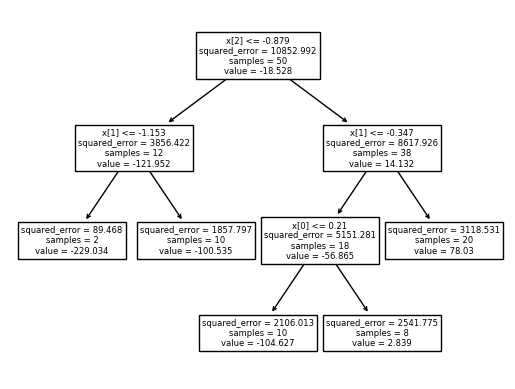

In [3]:
tree.plot_tree(regressor)
plt.show()

Exploring tree structure:

In [4]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
values = regressor.tree_.value

In [5]:
children_left

array([ 1,  7,  3,  5, -1, -1, -1, -1, -1], dtype=int64)

In [6]:
children_right

array([ 2,  8,  4,  6, -1, -1, -1, -1, -1], dtype=int64)

In [7]:
feature

array([ 2,  1,  1,  0, -2, -2, -2, -2, -2], dtype=int64)

In [8]:
threshold

array([-0.87932089, -1.1526942 , -0.34739607,  0.21025595, -2.        ,
       -2.        , -2.        , -2.        , -2.        ])

In [9]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

In [10]:
regressor.apply(X_test)

array([4, 4])

Exploring tree in each level:

In [11]:
print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 9 nodes and has the following tree structure:

node=0 is a split node with value=[[-18.52785519]]: go to node 1 if X[:, 2] <= -0.87932088971138 else to node 2.
	node=1 is a split node with value=[[-121.95151352]]: go to node 7 if X[:, 1] <= -1.152694195508957 else to node 8.
	node=2 is a split node with value=[[14.13224745]]: go to node 3 if X[:, 1] <= -0.3473960682749748 else to node 4.
		node=3 is a split node with value=[[-56.86472587]]: go to node 5 if X[:, 0] <= 0.2102559469640255 else to node 6.
		node=4 is a leaf node with value=[[78.02952343]].
			node=5 is a leaf node with value=[[-104.62743522]].
			node=6 is a leaf node with value=[[2.83866081]].
		node=7 is a leaf node with value=[[-229.03435438]].
		node=8 is a leaf node with value=[[-100.53494535]].


## Strategy to obtain nuisance-free cutoff:

### Implementing nuisance-adapted functions for each method

Implementing naive quantiles in the presence of nuisance parameter:

In [12]:
def naive_nuisance(
    kind,
    simulator,
    score,
    alpha,
    nuisance_idx,
    B=1000,
    N=100,
    naive_n=500,
    disable_tqdm=True,
    log_transf=False,
    glm_class = None,
):
    n_grid = int(B / naive_n)
    quantiles = {}

    if kind == "poisson":
        # given the complexity, reducing to only 10 grid if B > 5000
        nu_grid = np.linspace(0.51, 1.49, int(np.ceil(n_grid ** (1 / 2))))
        mu_grid = np.linspace(0.1, 4.9, int(np.ceil(n_grid ** (1 / 2))))


        for nu, mu in tqdm(itertools.product(nu_grid, mu_grid), 
                           desc="fitting monte carlo cutoffs",
                           ):
            theta_fixed = torch.tensor([nu, mu])
            repeated_thetas = theta_fixed.reshape(1, -1).repeat_interleave(
                repeats=naive_n * N, dim=0
            )
            X_samples = simulator(repeated_thetas)

            if log_transf:
                X_samples = torch.log(X_samples)

            X_dim = X_samples.shape[1]
            X_samples = X_samples.reshape(naive_n, N * X_dim)

            lambdas = score.compute_nuissance(
            thetas=repeated_thetas.numpy()[0:naive_n, :],
                X=X_samples.numpy(), nuissance_idx = nuisance_idx, disable_tqdm=disable_tqdm, posterior_marginalized = True,
            )

            quantiles[(nu, mu)] = np.quantile(lambdas, q=1 - alpha)

    if kind == "glm":
        idx_array = np.arange(0,4)
        par_idx = np.setdiff1d(idx_array, nuisance_idx)

        beta_b_nuis_space = np.linspace(-1.9, 1.9, 
                                        int(np.ceil(n_grid ** (1 / 4))))
        beta_0_nuis_space = np.linspace(-3, 3,
                                        int(np.ceil(n_grid ** (1 / 4))))
        phi_nuis_space = np.linspace(0.05,1.745,
                                     int(np.ceil(n_grid ** (1 / 4))))
        par_list = [beta_0_nuis_space, 
                    beta_b_nuis_space, 
                    beta_b_nuis_space,
                    phi_nuis_space]
        
        par_array = np.c_[list(itertools.product(*par_list))]
        for theta in par_array:
            lambdas = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = naive_n,
            idx_1 = par_idx,
        )
            quantiles[tuple(theta)] = np.quantile(lambdas, q=1 - alpha)
        
    return quantiles


def predict_naive_quantile(kind, theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        if kind == "weinberg":
            idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
            quantiles_list.append(quantiles_dict[idx])
        else:
            distances = np.linalg.norm(thetas_values - theta, axis=1)
            idx = thetas_values[np.argmin(distances)]
            quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

Implementing all methods nuisance cutoffs:

In [13]:
def TRUST_nuisance_cutoffs(
        trust_obj, 
        nuissance_idx,
        par_values,
        trust_quantiles,
        ):
    # returning all thresholds
    feature_array = np.array(trust_obj.cart.tree_.feature)
    threshold_array = np.array(trust_obj.cart.tree_.threshold)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # returning all index
    size = par_values.shape[1] + 1

    # idx list
    idx_array = np.arange(0, size)
    

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
            )

        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]

        if thres.shape[0] != 0:
            # choosing eps by pairwise distances
            dists = pairwise_distances(thres.reshape(-1, 1))
            upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
            eps = np.min(dists[upper_triangular_indices])*1/3

            nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

            i = 0
            for par in par_values:
                par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
                new_par = np.column_stack((par_array, nuis_values))

                # reordering columns
                new_par = new_par[:, par_reorder]

                # computing cutoffs for new par
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                # returning minimal value
                cutoff_nuis[i] = np.max(list_locart_quantiles)
                i += 1
        # if thres is empty, then TRUST does not depend on nuisance
        else:
            i = 0
            for par in par_values:
                new_par = np.column_stack((par, 0))
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                cutoff_nuis[i] = list_locart_quantiles[0]
                i += 1
            
    else:
        # finding index of parameter of interest
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        par_reorder = np.argsort(
            np.concatenate(
            (par_idx, nuissance_idx), axis = None)
            )
        
        # finding indexes for nuisance threshold
        idxs_thres = np.where(np.in1d(feature_array,nuissance_idx))
        thres = threshold_array[idxs_thres]

        # if there are any nuisance thresholds
        if thres.shape[0] != 0:
            feature_nuis = feature_array[idxs_thres]

            # looping through all analysed features
            feature_idx = np.unique(feature_nuis)
            used_idx_list = []
            nuis_list = []

            # looping through features
            for feature in feature_idx:
                idx = np.where(feature_nuis == feature)
                thres_sel = thres[idx]

                used_idx_list.append(np.where(nuissance_idx == feature)[0][0])

                if thres_sel.shape[0] > 1:
                    # choosing eps in this case
                    dists = pairwise_distances(thres_sel.reshape(-1, 1))
                    upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
                    eps = np.min(dists[upper_triangular_indices])*1/3
                else:
                    eps = 0.05

                nuis_values = np.concatenate(
                    (thres_sel - eps, thres_sel + eps), 
                    axis = None
                    )
                nuis_list.append(nuis_values)

            # array of used indexes
            used_idx_array = np.array(used_idx_list)
            
            # checking if any nuisance feature was not used as threshold  
            # and fixing a value to it
            idx_diff = np.setdiff1d(nuissance_idx, feature_idx)
            unused_idx_list = []
            if idx_diff.shape[0] != 0:
                for i in range(idx_diff.shape[0]):
                    unused_idx_list.append(
                        np.where(nuissance_idx == idx_diff[i])[0][0]
                        )
                    nuis_list.append(np.array([0]))
                # array of unused indexes
                unused_idx_array = np.array(unused_idx_list)

                # reordering all combinations
                all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]

                # correcting order
                nuisance_reorder = np.argsort(
                    np.concatenate(
                    (used_idx_array, unused_idx_array),
                    axis = None
                    ))

                nuis_values = all_nuis_combinations[:, nuisance_reorder]
            else:
                nuis_values = np.c_[list(itertools.product(*nuis_list))]
            
            
            i = 0
            for par in par_values:
                par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
                new_par = np.column_stack((par_array, nuis_values))

                # reordering columns
                new_par = new_par[:, par_reorder]

                # computing cutoffs for new par
                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                # returning minimal value
                cutoff_nuis[i] = np.max(list_locart_quantiles)
                i += 1
    
    # conditioning if the threshold does not depend on other parameters
        else:
            # make vector of zeroes for the other parameters
            zeroes = np.zeros((1, nuissance_idx.shape[0]))
            i = 0
            for par in par_values:
                if par.ndim == 0:
                    par_col = par.reshape(1,1)
                else:
                    par_col = par.reshape(1,-1)

                new_par = np.column_stack((par_col, zeroes))
                # reordering columns
                new_par = new_par[:, par_reorder]

                idxs = trust_obj.cart.apply(new_par)
                list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

                cutoff_nuis[i] = list_locart_quantiles[0]
                i += 1
    return cutoff_nuis

def TRUST_plus_nuisance_cutoff(
        trust_plus_obj,
        nuissance_idx,
        par_values,
        K = 100,
        strategy = "all_cutoffs",
        total_h_cutoffs = 50,
        compute_CI = False,
        alpha_CI = 0.05,
        ):
    n_trees = len(trust_plus_obj.RF.estimators_)
    threshold_list = []
    feature_list = []
    # first, fixing an strategy to derive a smart nuisance grid
    if strategy == "all_cutoffs":
        # returning all thresholds for each tree
        for tree in trust_plus_obj.RF.estimators_:
            feature_array = np.array(tree.tree_.feature)
            threshold_array = np.array(tree.tree_.threshold)

            idxs = np.where(feature_array == nuissance_idx)
            thres = threshold_array[idxs]
            feature_nuis = feature_array[idxs]
            
            threshold_list.extend(list(thres))
            feature_list.extend(list(feature_nuis))
        thres = np.array(threshold_list)

    elif strategy == "one_tree":
        feature_array = np.array(
            trust_plus_obj.nuisance_tree.tree_.feature
            )
        threshold_array = np.array(
            trust_plus_obj.nuisance_tree.tree_.threshold
            )
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]

    elif strategy == "horizontal_cutoffs":
        total_cutoffs = 0
        tree_position = 0
        # making list of features and thresholds
        tree_feature_list, tree_thres_list = [], []
        feature_list, thres_list = [], []
        # creating feature and tree threshold list
        for tree in trust_plus_obj.RF.estimators_:
            feature_array = np.array(tree.tree_.feature)
            threshold_array = np.array(tree.tree_.threshold)

            tree_feature_list.append(feature_array)
            tree_thres_list.append(threshold_array)
        
        # returning only the first thresholds in trees
        while total_cutoffs < total_h_cutoffs:
            for i in range(n_trees):
                curr_feature = tree_feature_list[i][tree_position]
                if isinstance(nuissance_idx, int):
                    if curr_feature == nuissance_idx:
                        thres_list.append(tree_thres_list[i][tree_position])
                        feature_list.append(curr_feature)
                        total_cutoffs += 1
                        if total_cutoffs == total_h_cutoffs:
                            break
                else:
                     if curr_feature in nuissance_idx:
                        thres_list.append(tree_thres_list[i][tree_position])
                        feature_list.append(curr_feature)
                        total_cutoffs += 1
                        if total_cutoffs == total_h_cutoffs:
                            break
            tree_position += 1
        thres = np.array(thres_list)
        feature_nuis = np.array(feature_list)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    if compute_CI:
        lower_bound_nuis, upper_bound_nuis = (
                np.zeros(par_values.shape[0]), 
                np.zeros(par_values.shape[0])
            )

    # returning all index
    size = par_values.shape[1] + 1
    # idx list
    idx_array = np.arange(0, size)

    # if only one parameters is nuisance
    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
            )
        
        # choosing eps by pairwise distances
        dists = pairwise_distances(thres.reshape(-1, 1))
        upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
        eps = np.min(dists[upper_triangular_indices])*1/3

        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
        print(f"Using {nuis_values.shape[0]} nuisance candidates")

        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
    else:
        # first obtaining the nuisance grid
        # reordering parameters order
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        par_reorder = np.argsort(
            np.concatenate((par_idx, nuissance_idx), axis = None)
        )  

        # looping through all used nuisance features
        feature_idx = np.unique(feature_nuis)

        nuis_list = []
        used_idx_list = []
        for feature in feature_idx:
            idxs = np.where(feature_nuis == feature)
            used_idx_list.append(np.where(nuissance_idx == feature)[0][0])
            thres_sel = thres[idxs]

            dists = pairwise_distances(thres_sel.reshape(-1, 1))
            upper_triangular_indices = np.triu_indices(dists.shape[0], k=1)
            eps = np.min(dists[upper_triangular_indices])*1/3

            nuis_values = np.concatenate(
                (thres_sel - eps, thres_sel + eps), 
                axis = None
                )
            nuis_list.append(nuis_values)

        used_idx_array = np.array(used_idx_list)
        
        # checking if any feature didnt appear and fixing a value to it
        idx_diff = np.setdiff1d(nuissance_idx, feature_idx)
        unused_idx_list = []
        if idx_diff.shape[0] != 0:
            for i in range(idx_diff.shape[0]):
                nuis_list.append(np.array([0]))
                unused_idx_list.append(
                        np.where(nuissance_idx == idx_diff[i])[0][0]
                        )
                nuis_list.append(np.array([0]))
                unused_idx_array = np.array(unused_idx_list)

            # reordering all combinations
            all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]
            nuisance_reorder = np.argsort(
                np.concatenate(
                    (used_idx_array, unused_idx_array),
                    axis = None
                    )
                    )
            all_nuis_combinations = all_nuis_combinations[:, nuisance_reorder]
        else:
            all_nuis_combinations = np.c_[list(itertools.product(*nuis_list))]

        # finally, obtaining nuisance cutoffs
        print(f"Total number of combinations: {all_nuis_combinations.shape[0]}")
        i = 0
        max_list = []

        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (all_nuis_combinations.shape[0], 1))
            new_par = np.column_stack((par_array, all_nuis_combinations))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            # if compute_CI is TRUE, then we also compute the lower and 
            # upper bound for each cutoff
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)
            # index of max
            max_idx = np.argmax(cutoff_vector)
            if compute_CI:
                par_CI = new_par[max_idx, :].reshape(1, -1)
                _, lower_bound, upper_bound = (
                    trust_plus_obj.compute_cutoffs(
                    par_CI, 
                    K = K, 
                    compute_CI = compute_CI,
                    alpha_CI = alpha_CI
                    )
                )
                lower_bound_nuis[i] = lower_bound[0]
                upper_bound_nuis[i] = upper_bound[0]
            # list of maximum 
            max_list.append(new_par[max_idx, :])

            # returning supremum of cutoff
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
    
    if compute_CI:
        return cutoff_nuis, lower_bound_nuis, upper_bound_nuis, max_list
    else:
        if isinstance(nuissance_idx, int):
            return cutoff_nuis
        else:
            return cutoff_nuis, max_list

def boosting_nuisance_cutoff(
        boosting_obj,
        nuisance_grid,
        nuissance_idx,
        par_values,
        ):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # returning all index
    size = par_values.shape[1] + 1
    # idx list
    idx_array = np.arange(0, size)
    if isinstance(nuissance_idx, int):
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
    else:
        par_idx = np.setdiff1d(idx_array, nuissance_idx)
        
    par_reorder = np.argsort(
        np.concatenate((par_idx, nuissance_idx), axis = None)
        )

    i = 0
    for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
        par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
        new_par = np.column_stack((par_array, nuisance_grid))

        # reordering columns
        new_par = new_par[:, par_reorder]

        # computing cutoffs for new par
        cutoff_vector = boosting_obj.predict(new_par)
        if(i == 0):
            print(cutoff_vector)

        # returning minimal value
        cutoff_nuis[i] = np.max(cutoff_vector)
        i += 1
    return cutoff_nuis

def naive_nuisance_cutoff(
        naive_quantiles,
        nuisance_grid,
        nuisance_idx,
        par_values,
):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    if isinstance(nuisance_idx, int):
        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuisance_idx)]
        par_reorder = np.concatenate((par_idx, nuisance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value in boosting"):
            par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
            new_par = np.column_stack((par_array, nuisance_grid))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs with naive
            cutoff_vector = np.array(predict_naive_quantile(kind = "poisson", theta_grid = new_par, quantiles_dict = naive_quantiles))

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
        return cutoff_nuis
    # TODO: nuisance with more than 1 dimension

def naive_nuisance_cutoff_glm(
        naive_quantiles,
        nuisance_grid,
        nuisance_idx,
        par_values,
        ):
    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])
    idx_array = np.arange(0, 4)

    # reordering parameters order
    par_idx = np.setdiff1d(idx_array, nuisance_idx)
    par_reorder = np.argsort(
            np.concatenate((par_idx, nuisance_idx), axis = None)
        )
    
    i = 0
    for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
        par_array = np.tile(par, reps = (nuisance_grid.shape[0], 1))
        new_par = np.column_stack((par_array, nuisance_grid))

        # reordering columns
        new_par = new_par[:, par_reorder]

        # computing cutoffs with naive
        cutoff_vector = np.array(predict_naive_quantile(kind = "poisson", theta_grid = new_par, quantiles_dict = naive_quantiles))

        # returning minimal value
        cutoff_nuis[i] = np.max(cutoff_vector)
        i += 1
    return cutoff_nuis

Function to compute coverage and real nuisance cutoff:

In [14]:
# computing coverage for the poisson example
def coverage_nuisance(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      cutoff_boosting,
                      cutoff_naive,
                      valid_thetas,
                      par_space,
                      score,
                      simulator,
                      nuisance_idx,
                      par_idx,
                      n_lambda = 1000,
                      n = 5,):
    
    coverage_trust, coverage_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    coverage_boosting, coverage_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    cutoff_trust_list, cutoff_trust_plus_list = [], []
    real_cutoff_list, boosting_cutoff_list = [], []
    naive_cutoff_list = []
    stat_list, mu_list, problem_cutoff = [], [], []
    i = 0

    # computing coverage for trust, trust++, boosting and naive
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(par_space == theta[par_idx])
        # generating stats
        theta_repeated = torch.tensor([theta], 
                                      dtype = torch.float32
                                      ).reshape(
                                          1, -1).repeat_interleave(
                                          repeats = n_lambda*n, 
                                          dim = 0
                                          )
        X_net = simulator(theta_repeated)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, n * X_dim)

        stat = score.compute_nuissance(
            theta_repeated.numpy()[0:n_lambda,:], 
            X_net.numpy(), 
            nuissance_idx = nuisance_idx, 
            disable_tqdm = True,
            posterior_marginalized=True,
            )
        
        real_cutoff = np.quantile(stat, q = 0.95)
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        coverage_boosting[i] = np.mean(stat <= cutoff_boosting[cut_idx])
        coverage_naive[i] = np.mean(stat <= cutoff_naive[cut_idx])

        # detecting cases where coverage is zero in TRUST
        if coverage_trust[i] < 0.1:
            stat_list.append(stat)
            mu_list.append(theta[1])
            problem_cutoff.append(cutoff_array_trust[cut_idx])
        
        # adding every cutoff in the list
        cutoff_trust_plus_list.append(cutoff_array_trust_plus[cut_idx])
        boosting_cutoff_list.append(cutoff_boosting[cut_idx])
        naive_cutoff_list.append(cutoff_naive[cut_idx])

        # returning cutoff for TRUST to evaluate
        cutoff_trust_list.append(cutoff_array_trust[cut_idx])
        real_cutoff_list.append(real_cutoff)
        i += 1
    
    # transforming the lists into arrays
    trust_grid_cutoff_array = np.array(cutoff_trust_list)
    trust_grid_plus_cutoff_array = np.array(cutoff_trust_plus_list)
    boosting_cutoff_array = np.array(boosting_cutoff_list)
    naive_cutoff_array = np.array(naive_cutoff_list)
    
    # computing real nuisance cutoff using real cutoffs from past loop
    real_cutoff =  np.array(real_cutoff_list)
    real_nuisance_cutoff_list = []
    for theta in tqdm(valid_thetas, desc = "Computing real cutoffs: "):
        cut_idxs = np.where(valid_thetas[:, par_idx] == theta[par_idx])
        real_nuisance_cutoff = np.max(real_cutoff[cut_idxs])
        real_nuisance_cutoff_list.append(real_nuisance_cutoff)
    
    # transforming the list into array
    real_grid_cutoff_array = np.array(real_nuisance_cutoff_list)
    
    # computing TRUST, TRUST++, Boosting and real cutoffs only for mu
    # in poisson example
    real_mu_list, trust_mu_list, trust_plus_mu_list = [], [], []
    boosting_mu_list = []
    for mu in tqdm(par_space, desc = "Computing cutoffs only for mu: "):
        cut_idx = np.where(valid_thetas[:, 1] == mu)
        real_mu_nuisance_cutoff = np.unique(
            real_grid_cutoff_array[cut_idx])[0]
        trust_mu_nuisance_cutoff = np.unique(
            trust_grid_cutoff_array[cut_idx])[0]
        trust_plus_mu_nuisance_cutoff = np.unique(
            trust_grid_plus_cutoff_array[cut_idx])[0]
        boosting_mu_nuisance_cutoff = np.unique(
            boosting_cutoff_array[cut_idx])[0]
        

        boosting_mu_list.append(boosting_mu_nuisance_cutoff)
        real_mu_list.append(real_mu_nuisance_cutoff)
        trust_mu_list.append(trust_mu_nuisance_cutoff)
        trust_plus_mu_list.append(trust_plus_mu_nuisance_cutoff)

    # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
    # trust plus cutoff, real cutoff for mu, trust cutoff for mu and
    # trust plus cutoff for mu
        return [coverage_trust, 
        coverage_trust_plus,
        trust_grid_cutoff_array, 
        real_grid_cutoff_array,
        trust_grid_plus_cutoff_array,
        np.array(real_mu_list),
        np.array(trust_mu_list),
        np.array(trust_plus_mu_list),
        stat_list,
        mu_list,
        problem_cutoff,
        coverage_boosting, #11
        boosting_cutoff_array, #12
        coverage_naive, #13
        naive_cutoff_array, #14
        ]

Computing coverage for GLM example:

In [15]:
def coverage_nuisance_glm(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      cutoff_boosting,
                      cutoff_naive,
                      valid_thetas,
                      par_space,
                      glm_class,
                      par_idx,
                      n_lambda = 500,
                      alpha = 0.05):
    
    coverage_trust, coverage_trust_plus = np.zeros(
        valid_thetas.shape[0]), np.zeros(
            valid_thetas.shape[0])
    coverage_boosting = np.zeros(valid_thetas.shape[0])
    coverage_naive = np.zeros(valid_thetas.shape[0])
    cutoff_trust_list, cutoff_trust_plus_list = [], []
    real_cutoff_list, boosting_cutoff_list = [], []
    naive_cutoff_list = []
    stat_list = []
    i = 0

    # asymptotic cutoff and coverage vector
    coverage_asymp = np.zeros(valid_thetas.shape[0])
    cutoff_asymp = st.chi2.ppf(1 - alpha, df = par_idx.shape[0])
    
    # computing coverage for trust, trust++, boosting and naive
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(par_space == theta[par_idx])
        # generating stats
        stat = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = n_lambda,
            idx_1 = par_idx,
        )
        
        real_cutoff = np.quantile(stat, q = 0.95)
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        coverage_boosting[i] = np.mean(stat <= cutoff_boosting[cut_idx])
        coverage_asymp[i] = np.mean(stat <= cutoff_asymp)
        coverage_naive[i] = np.mean(stat <= cutoff_naive[cut_idx])
        
        # adding every cutoff in the list
        cutoff_trust_plus_list.append(cutoff_array_trust_plus[cut_idx])
        boosting_cutoff_list.append(cutoff_boosting[cut_idx])
        naive_cutoff_list.append(cutoff_naive[cut_idx])

        # returning cutoff for TRUST to evaluate
        cutoff_trust_list.append(cutoff_array_trust[cut_idx])
        real_cutoff_list.append(real_cutoff)
        i += 1
    
    # transforming the lists into arrays
    trust_grid_cutoff_array = np.array(cutoff_trust_list)
    trust_grid_plus_cutoff_array = np.array(cutoff_trust_plus_list)
    boosting_cutoff_array = np.array(boosting_cutoff_list)
    naive_cutoff_array = np.array(naive_cutoff_list)
    
    # computing real nuisance cutoff using real cutoffs from past loop
    real_cutoff =  np.array(real_cutoff_list)
    real_nuisance_cutoff_list = []
    for theta in tqdm(valid_thetas, desc = "Computing real cutoffs: "):
        cut_idxs = np.where(
            valid_thetas[:, par_idx] == theta[par_idx]
            )[0]
        real_nuisance_cutoff = np.max(real_cutoff[cut_idxs])
        real_nuisance_cutoff_list.append(real_nuisance_cutoff)
    
    # transforming the list into array
    real_grid_cutoff_array = np.array(real_nuisance_cutoff_list)
    
    # computing TRUST, TRUST++, Boosting and real cutoffs only for mu
    # in poisson exampleScreenshot from 2024-09-17 18-18-13
    real_mu_list, trust_mu_list, trust_plus_mu_list = [], [], []
    boosting_mu_list = []
    for mu in tqdm(par_space, desc = "Computing cutoffs only for mu: "):
        cut_idx = np.where(valid_thetas[:, 1] == mu)
        real_mu_nuisance_cutoff = np.unique(
            real_grid_cutoff_array[cut_idx])[0]
        trust_mu_nuisance_cutoff = np.unique(
            trust_grid_cutoff_array[cut_idx])[0]
        trust_plus_mu_nuisance_cutoff = np.unique(
            trust_grid_plus_cutoff_array[cut_idx])[0]
        boosting_mu_nuisance_cutoff = np.unique(
            boosting_cutoff_array[cut_idx])[0]
        
        

        boosting_mu_list.append(boosting_mu_nuisance_cutoff)
        real_mu_list.append(real_mu_nuisance_cutoff)
        trust_mu_list.append(trust_mu_nuisance_cutoff)
        trust_plus_mu_list.append(trust_plus_mu_nuisance_cutoff)

    # trust coverage, trus plus coverage, trust cutoff, nuisance cutoff, 
    # trust plus cutoff, real cutoff for mu, trust cutoff for mu and
    # trust plus cutoff for mu
        return [coverage_trust, 
        coverage_trust_plus,
        trust_grid_cutoff_array, 
        real_grid_cutoff_array,
        trust_grid_plus_cutoff_array,
        np.array(real_mu_list),
        np.array(trust_mu_list),
        np.array(trust_plus_mu_list),
        stat_list,
        # mu_list,
        # problem_cutoff,
        coverage_boosting, #9
        boosting_cutoff_array, #10
        coverage_asymp, #11
        coverage_naive, #12
        naive_cutoff_array, #13
        # coverage_naive, #14
        ]

Function to compute distance to oracle coverage:

In [16]:
def oracle_dist(coverage_array_trust, 
                coverage_array_trust_plus,
                coverage_boosting,
                coverage_naive,
                cutoff_real,
                valid_thetas,
                simulator,
                score,
                nuisance_idx,
                seed = None,
                n_lambda = 1000,
                n_rep = 50,
                n = 5,
                glm = False,
                X_mat = None,
                alpha_gamma = 1.5,
                ):
    
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
    
    mean_diff_trust, mean_diff_trust_plus = np.zeros(n_rep), np.zeros(n_rep)
    mean_diff_boosting, mean_diff_naive= np.zeros(n_rep), np.zeros(n_rep)

    for i in tqdm(range(0, n_rep), desc = "Repeating computation: "):
        diff_trust, diff_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        diff_boosting, diff_naive = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        j = 0
        # computing coverage for trust, trust++ and boosting
        for theta in valid_thetas:
            if not glm:
                # generating stats
                theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)

                X_net = simulator(theta_repeated)
                X_dim = X_net.shape[1]
                X_net = X_net.reshape(n_lambda, n * X_dim)
            else:
                # generating stats
                theta_repeated = torch.tensor([theta], dtype = 
                                              torch.float32).reshape(1, -1).repeat_interleave(repeats = n_lambda, dim = 0)

                X_net = simulator(theta_repeated, X_mat = X_mat, 
                                  alpha = alpha_gamma,)

            stat = score.compute_nuissance(
                theta_repeated.numpy()[0:n_lambda,:], 
                X_net.numpy(), 
                nuissance_idx = nuisance_idx, 
                disable_tqdm = True,
                posterior_marginalized=True,
                )
            
            # real coverage
            oracle_coverage = np.mean(stat <= cutoff_real[j])
            
            diff_trust[j] = np.abs(coverage_array_trust[j] - oracle_coverage)
            diff_trust_plus[j] = np.abs(
                coverage_array_trust_plus[j] - oracle_coverage)
            diff_boosting[j] = np.abs(coverage_boosting[j] - oracle_coverage)
            diff_naive[j] = np.abs(coverage_naive[j] - oracle_coverage)
            j += 1

        mean_diff_trust[i] = np.mean(diff_trust)
        mean_diff_trust_plus[i] = np.mean(diff_trust_plus)
        mean_diff_boosting[i] = np.mean(diff_boosting)
        mean_diff_naive[i] = np.mean(diff_naive)
    
    mean_diff_trust_overall = np.mean(mean_diff_trust)
    mean_diff_trust_plus_overall= np.mean(mean_diff_trust_plus)
    mean_diff_boosting_overall = np.mean(mean_diff_boosting)
    mean_diff_naive_overall = np.mean(mean_diff_naive)

    n_exp = np.sqrt(n_rep)
    se_trust = 2*np.std(mean_diff_trust)/n_exp
    se_trust_plus = 2*np.std(mean_diff_trust_plus)/n_exp
    se_boosting = 2*np.std(mean_diff_boosting)/n_exp
    se_naive = 2*np.std(mean_diff_naive)/n_exp



    diff_data = pd.DataFrame({
        "methods": ["TRUST", "TRUST++", "Boosting", "MC"],
        "diff": [
            mean_diff_trust_overall, 
            mean_diff_trust_plus_overall, 
            mean_diff_boosting_overall, 
            mean_diff_naive_overall,
            ],
        "se*2": [se_trust, se_trust_plus, se_boosting, se_naive]
    })
    
    return [diff_trust,
            diff_trust_plus,
            diff_boosting,
            diff_naive,
            diff_data
            ]

Computing distance to oracle in GLM:

In [17]:
def oracle_dist_glm(coverage_array_trust, 
                coverage_array_trust_plus,
                coverage_boosting,
                coverage_asymp,
                coverage_naive,
                cutoff_real,
                valid_thetas,
                glm_class,
                par_idx,
                new_seed = 45,
                n_lambda = 1000,
                n_rep = 50,
                ):
    glm_class.change_seed(new_seed)
    mean_diff_trust, mean_diff_trust_plus = np.zeros(n_rep), np.zeros(n_rep)
    mean_diff_boosting= np.zeros(n_rep)
    mean_diff_asymp = np.zeros(n_rep)
    mean_diff_naive = np.zeros(n_rep)

    for i in tqdm(range(0, n_rep), desc = "Repeating computation: "):
        diff_trust, diff_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
        diff_boosting = np.zeros(valid_thetas.shape[0])
        diff_naive = np.zeros(valid_thetas.shape[0])
        diff_asymp = np.zeros(valid_thetas.shape[0])
        j = 0
        # computing coverage for trust, trust++ and boosting
        for theta in valid_thetas:
            stat = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = n_lambda,
            idx_1 = par_idx,
        )
            
            # real coverage
            oracle_coverage = np.mean(stat <= cutoff_real[j])
            
            diff_trust[j] = np.abs(coverage_array_trust[j] - oracle_coverage)
            diff_trust_plus[j] = np.abs(
                coverage_array_trust_plus[j] - oracle_coverage)
            diff_boosting[j] = np.abs(coverage_boosting[j] - oracle_coverage)
            diff_asymp[j] = np.abs(coverage_asymp[j] - oracle_coverage)
            diff_naive[j] = np.abs(coverage_naive[j] - oracle_coverage)
            j += 1

        mean_diff_trust[i] = np.mean(diff_trust)
        mean_diff_trust_plus[i] = np.mean(diff_trust_plus)
        mean_diff_boosting[i] = np.mean(diff_boosting)
        mean_diff_asymp[i] = np.mean(diff_asymp)
        mean_diff_naive[i] = np.mean(diff_naive)
    
    mean_diff_trust_overall = np.mean(mean_diff_trust)
    mean_diff_trust_plus_overall= np.mean(mean_diff_trust_plus)
    mean_diff_boosting_overall = np.mean(mean_diff_boosting)
    mean_diff_asymp_overall = np.mean(mean_diff_asymp)
    mean_diff_naive_overall = np.mean(mean_diff_naive)

    n_exp = np.sqrt(n_rep)
    se_trust = 2*np.std(mean_diff_trust)/n_exp
    se_trust_plus = 2*np.std(mean_diff_trust_plus)/n_exp
    se_boosting = 2*np.std(mean_diff_boosting)/n_exp
    se_naive = 2*np.std(mean_diff_naive)/n_exp
    se_asymp = 2*np.std(mean_diff_asymp)/n_exp


    diff_data = pd.DataFrame({
        "methods": ["TRUST", "TRUST++", "Boosting", "MC", "Asymptotic"],
        "diff": [
            mean_diff_trust_overall, 
            mean_diff_trust_plus_overall, 
            mean_diff_boosting_overall,
            mean_diff_naive_overall,
            mean_diff_asymp_overall,
            ],
        "se*2": [se_trust, se_trust_plus, se_boosting, se_naive, se_asymp]
    })
    
    return [diff_trust,
            diff_trust_plus,
            diff_boosting,
            diff_data
            ]

We can obtain nuissance-free cutoff through minimizing cutoff over all possible threshold values for the nuissance parameter $\nu$. Testing this approach in a simple nuissance example:

### Poisson model with two parameters, one nuisance:

In [57]:
# nu parameter space and prior: (0, 1.5)
# mu parameter space and prior: (0, 5)
# hyperparameters fixed: s = 15, b = 70, tau = 1 (same as the LF2I paper)
def prior(n):
    m = Uniform(torch.tensor([0.5, 0.0]), torch.tensor([1.5, 5.0]))
    return m.sample(n)

def simulator(theta, s = 15, b = 70, tau = 1):
    b_par = theta[:,0]*b*tau
    s_par = theta[:,0]*b + theta[:, 1]*s
    par = torch.stack((b_par, s_par), -1).float()
    m = Poisson(par)
    return m.sample()

fitting posterior estimator only on $\mu$:

Fitting normalizing flows posterior estimator:  38%|███▊      | 770/2000 [05:31<08:49,  2.32it/s]

Early stopping at epoch 770
a


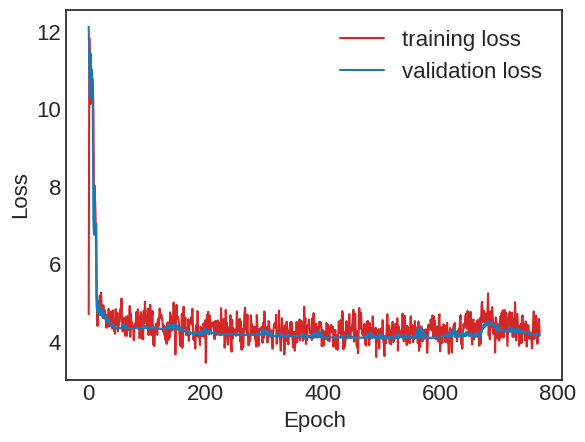

In [58]:
nflow_poisson_model = fit_post_model(
    simulator, 
    prior, 
    B_model = 25000, 
    n = 1, 
    seed = 125,
    nuisance_idx = 0, 
    split_seed = 45,
    patience = 200,
    n_flows = 4,
    poisson = True)

Fitting BFF score and setting $B$ and $n$ to fit our methods:

In [59]:
bff_score = BFFScore(nflow_poisson_model, is_fitted = True)
bff_score.fit()
B = 10000
n  = 1

Creating samples to train both TRUST and TRUST++ with majority votes:

In [60]:
torch.manual_seed(125)
torch.cuda.manual_seed(125)

print("Sampling from the parameter prior:")
thetas_sim = prior((B, ))

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

repeated_thetas = thetas_sim.repeat_interleave(repeats=n, dim=0)
X_net = simulator(repeated_thetas)
X_dim = X_net.shape[1]
X_net = X_net.reshape(B, n * X_dim)

print("Obtaining statistics sample: ")
model_lambdas = bff_score.compute_nuissance(
    model_thetas.numpy(), X_net.numpy(), nuissance_idx = 0, disable_tqdm=False, posterior_marginalized = True,
    )

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    model_thetas.numpy(), model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    model_thetas.numpy(),
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    fit_nuisance_tree=True,
    K=100,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(model_thetas.numpy(), model_lambdas)

Sampling from the parameter prior:
Obtaining statistics sample: 
Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


HistGradientBoostingRegressor(early_stopping=True, loss='quantile', max_depth=3,
                              n_iter_no_change=15, quantile=0.95,
                              random_state=105)

Fitting naive quantiles:

In [61]:
naive_quantiles = naive_nuisance(
        kind="poisson",
        simulator=simulator,
        score = bff_score,
        nuisance_idx=0,
        alpha=0.05,
        B=B,
        N=n,
        naive_n=500,
        log_transf=False,
    )

fitting monte carlo cutoffs: 25it [00:00, 46.25it/s]


Fitting TRUST, TRUST++ and Boosting nuisance cutoffs:

In [62]:
nu_space = np.linspace(0.55, 1.49, 100)
mu_space = np.linspace(0.1, 4.85, 100)

# returning all combinations for fitting nuissance cutoffs
valid_thetas = np.c_[list(itertools.product(nu_space, mu_space))]

# returning meshgrid for plotting
mu_v, nu_v = np.meshgrid(mu_space, nu_space)

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = 0, 
    par_values = mu_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
    strategy="horizontal_cutoffs",
    K = 100,
    total_h_cutoffs = 300,
)

cutoff_mu_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = np.linspace(0.55, 1.49, 600), 
    nuissance_idx=0,
    par_values = mu_space.reshape(-1, 1),
    )

Using 600 nuisance candidates


Computing nuisance cutoffs for each parameter value: 100%|██████████| 100/100 [01:31<00:00,  1.10it/s]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 100/100 [00:00<00:00, 537.66it/s]

[-0.09753607 -0.09753607 -0.10512104 -0.10512104 -0.10512104 -0.10512104
 -0.10620199 -0.10620199 -0.10620199 -0.10620199 -0.10620199 -0.10620199
 -0.10620199 -0.10620653 -0.10620653 -0.10619963 -0.10619963 -0.10619963
 -0.10619963 -0.10619963 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0.12487043
 -0.12487043 -0.12487043 -0.12487043 -0.12487043 -0

Computing nuisance cutoffs:

In [63]:
cutoff_mu_naive = naive_nuisance_cutoff(
    naive_quantiles,
    nuisance_grid=np.linspace(0.55, 1.49, 600),
    nuisance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
)

Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 100/100 [00:00<00:00, 168.08it/s]


Analysing cutoffs:

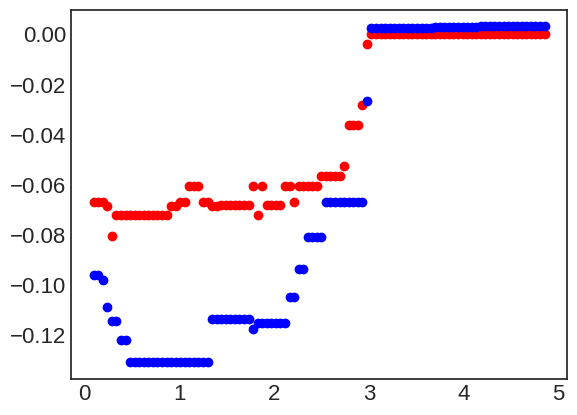

In [64]:
plt.scatter(mu_space, 
            cutoff_mu_TRUST_plus, color = "red")
plt.scatter(mu_space, cutoff_mu_boosting, color = "blue")

Analysing coverage:

In [65]:
nuisance_poisson_list = coverage_nuisance(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus,
    cutoff_mu_boosting, 
    cutoff_mu_naive,
    valid_thetas, 
    par_space = mu_space,
    par_idx = 1,
    nuisance_idx = 0,
    simulator = simulator,
    score = bff_score,
    n_lambda = 1000,
    n = 1,
    )

Assessing :   0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_6814/3692298281.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/utils/tensor_new.cpp:275.)
  theta_repeated = torch.tensor([theta],
Computing cutoffs only for mu:   0%|          | 0/100 [00:00<?, ?it/s]


Plotting coverage for every combination of $\nu$ and $\mu$:

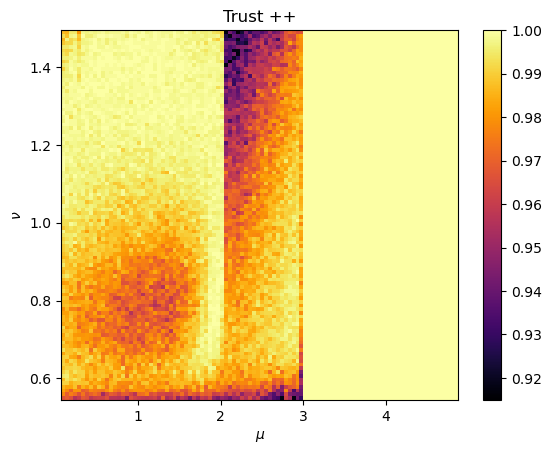

In [27]:
z = nuisance_poisson_list[1].reshape(100, 100)

fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[1]),
                    vmax=1,
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title('Trust ++')
plt.show()

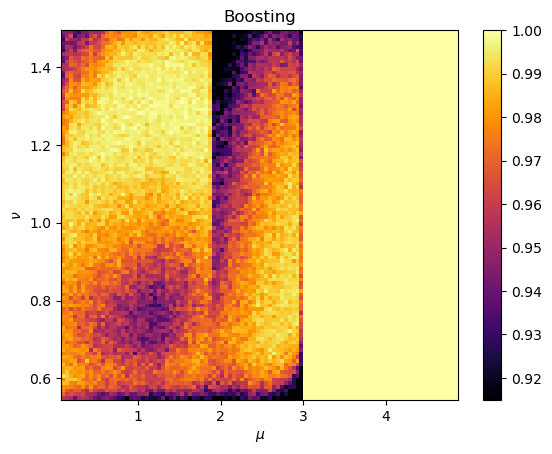

In [33]:
z = nuisance_poisson_list[11].reshape(100, 100)

fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[1]),
                    vmax=1,
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title('Boosting')
plt.show()

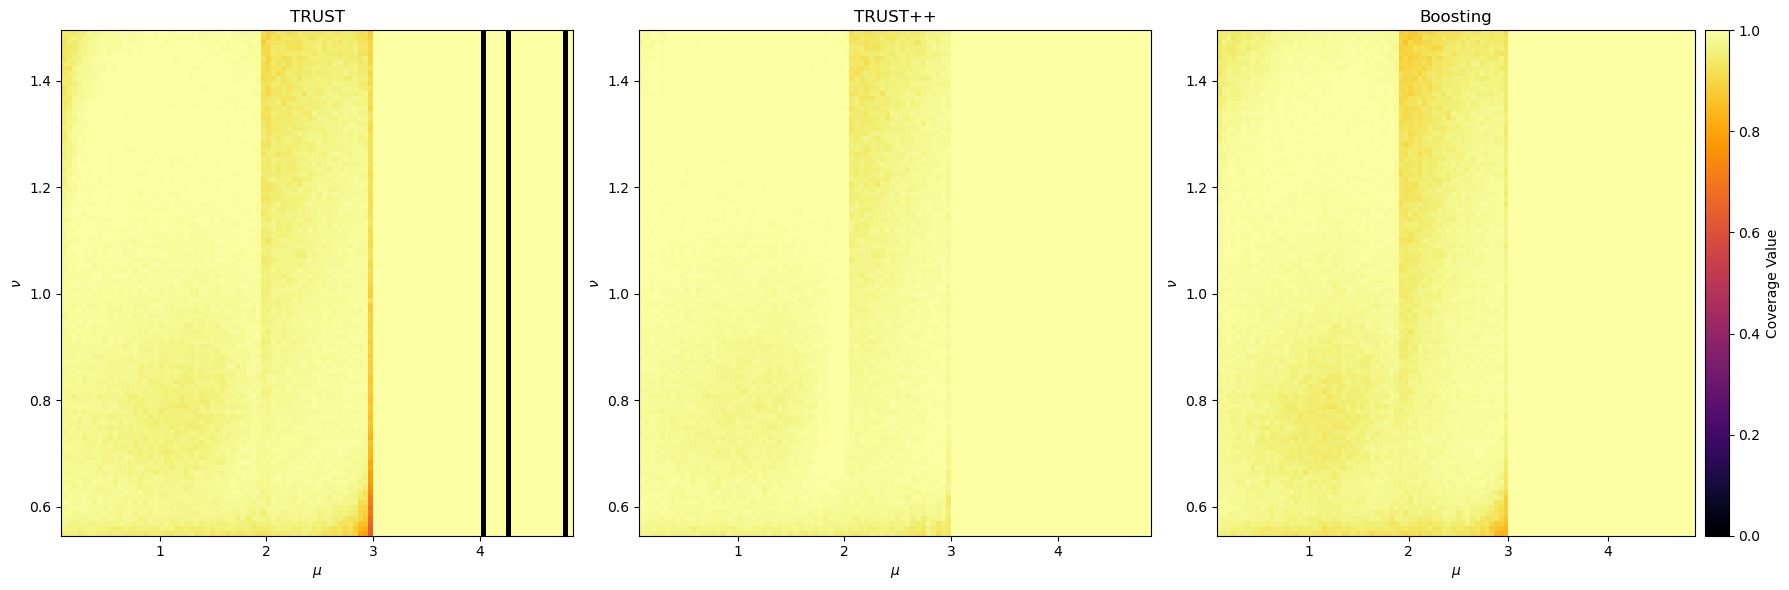

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
trust_plus_coverage = nuisance_poisson_list[1].reshape(100, 100)
trust_coverage = nuisance_poisson_list[0].reshape(100, 100)
boosting_coverage = nuisance_poisson_list[11].reshape(100, 100)
naive_coverage = nuisance_poisson_list[13].reshape(100, 100)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_coverage), 
    np.min(trust_coverage), 
    np.min(boosting_coverage),
)
global_vmax = max(
    np.max(trust_plus_coverage), 
    np.max(trust_coverage), 
    np.max(boosting_coverage),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot TRUST Coverage
pc1 = axes[0].pcolormesh(mu_v, nu_v, trust_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST")

# Plot TRUST Plus Coverage
pc2 = axes[1].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_coverage, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("TRUST++")


# Plot Boosting Coverage
pc3 = axes[2].pcolormesh(mu_v, nu_v, boosting_coverage, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[2].set_ylabel(r'$\nu$')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc3, cax=cax)
cbar.set_label('Coverage Value')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()

Plotting heatmap for LOCART cutoffs:

Text(0.5, 1.0, 'TRUST cutoffs')

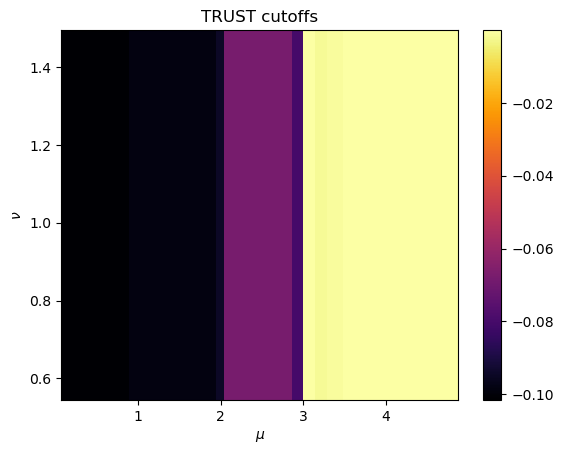

In [30]:
z = nuisance_poisson_list[2].reshape(100, 100)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[2]),
                    vmax=np.max(nuisance_poisson_list[2]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST cutoffs")

Real cutoffs:

Text(0.5, 1.0, 'Real cutoffs')

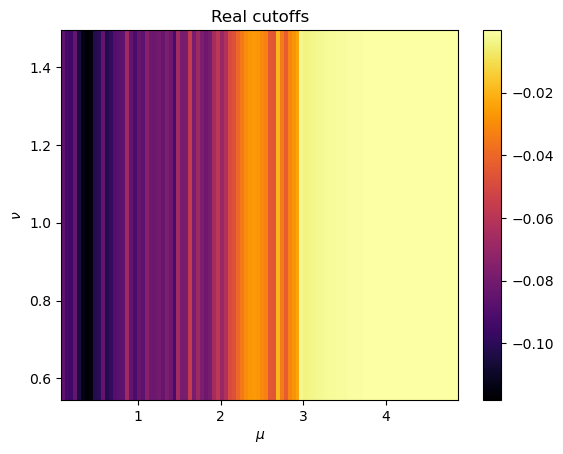

In [32]:
z = nuisance_poisson_list[3].reshape(100, 100)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[3]),
                    vmax=np.max(nuisance_poisson_list[3]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("Real cutoffs")

Text(0.5, 1.0, 'TRUST++ cutoffs')

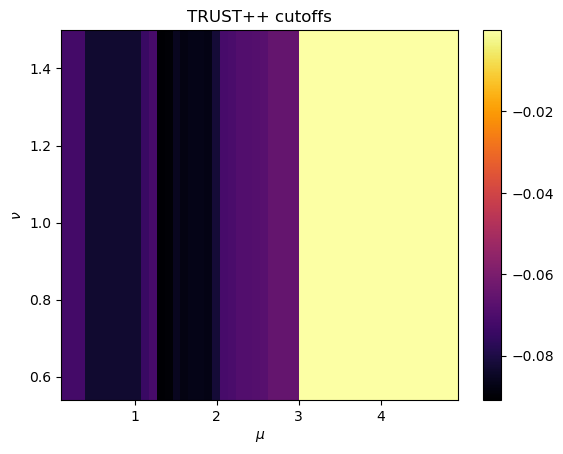

In [35]:
z = nuisance_poisson_list[4].reshape(50, 50)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, 
                    nu_v, 
                    z, 
                    vmin= np.min(nuisance_poisson_list[4]),
                    vmax=np.max(nuisance_poisson_list[4]), 
                    cmap = "inferno")
fig.colorbar(pc)
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\mu$')
plt.title("TRUST++ cutoffs")

#### Plotting and evaluating difference in coverage between each method and the oracle:

Obtaining mean difference of each method coverage compared to the oracle coverage:

In [66]:
trust_plus_coverage = nuisance_poisson_list[1]
trust_coverage = nuisance_poisson_list[0]
boosting_coverage = nuisance_poisson_list[11]
real_cutoffs = nuisance_poisson_list[3]
naive_coverage = nuisance_poisson_list[13]


diff_list = oracle_dist(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    naive_coverage,
    real_cutoffs,
    valid_thetas,
    n_rep = 15,
    simulator = simulator,
    score = bff_score,
    nuisance_idx = 0,
    n = 1,
    glm = False,
    seed = 750
)

Repeating computation: 100%|██████████| 15/15 [52:35<00:00, 210.36s/it]


Mean difference to oracle with standard error:

In [67]:
diff_list[4]

,methods,diff,se*2
0,TRUST,0.036910,0.000014
1,TRUST++,0.004131,0.000015
2,Boosting,0.008435,0.000012
3,MC,0.146010,0.000011


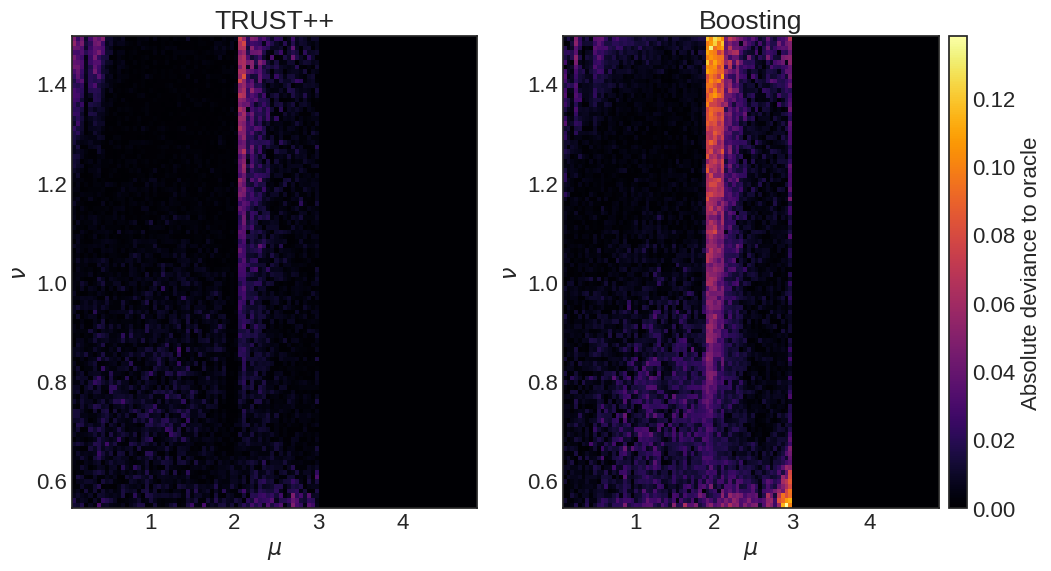

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
trust_plus_diff = diff_list[1].reshape(100, 100)
trust_diff = diff_list[0].reshape(100, 100)
boosting_diff = diff_list[2].reshape(100, 100)

# Calculate global vmin and vmax
global_vmin = min(
    np.min(trust_plus_diff), 
    np.min(boosting_diff),
)
global_vmax = max(
    np.max(trust_plus_diff),  
    np.max(boosting_diff),
)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot TRUST Plus Coverage
pc1 = axes[0].pcolormesh(
    mu_v, 
    nu_v, 
    trust_plus_diff, 
    vmin=global_vmin, 
    vmax=global_vmax, 
    cmap='inferno',
    )
axes[0].set_ylabel(r'$\nu$')
axes[0].set_xlabel(r'$\mu$')
axes[0].set_title("TRUST++")


# Plot Boosting Coverage
pc2 = axes[1].pcolormesh(mu_v, nu_v, boosting_diff, 
                         vmin=global_vmin, 
                         vmax=global_vmax, 
                         cmap='inferno')
axes[1].set_ylabel(r'$\nu$')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_title("Boosting")

# Create a colorbar axis next to the third subplot
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add a common colorbar
cbar = fig.colorbar(pc2, cax=cax)
cbar.set_label('Absolute deviance to oracle')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right margin to make space for the colorbar

# Show the plot
plt.show()
fig.savefig("figures/oracle_diff_poisson.pdf", format="pdf")

### GLM model with two parameters, one of interest:

In [20]:
# Step 1: Generate synthetic data
np.random.seed(45)
n_samples = 50
X = np.random.uniform(1, 10, (n_samples,2))
# Generate response variable with Gamma noise
y = np.random.gamma(
    shape=2, 
    scale=(1/2)*np.exp(0.5 * X[:, 0]), 
    size=n_samples)
X_new = sm.add_constant(X)

# Step 2: Fit a GLM model with Gamma distribution and log link function
glm_gamma = sm.GLM(y, X_new, family=sm.families.Gamma(link=sm.families.links.log()), )
result = glm_gamma.fit()

# Step 3: Summarize the results
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       47
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.67456
Method:                          IRLS   Log-Likelihood:                -198.00
Date:                Thu, 07 Nov 2024   Deviance:                       28.019
Time:                        16:00:03   Pearson chi2:                     31.7
No. Iterations:                    15   Pseudo R-squ. (CS):             0.8984
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2875      0.346     -0.830      0.4

/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Implementing prior for GLM, using common priors in literature:

In [18]:
# beta_0 parameters space and prior: N(0,16)
# beta_1 parameter space and prior: N(0,1)
# beta_2 parameter space and prior: N(0,1)
# using log link function
# beta_0 fixed as 1
# phi ~ exp(1)
# simulating covariate matrix first:
n = 50
rng = np.random.default_rng(85)

X_mat = rng.uniform((-1, -1), (1, 1), (n, 2))

def prior(n, rng, intercept_value = None, dim = 2):
    if intercept_value is None:
        betas = rng.normal(loc = 
                       np.repeat(0, dim + 1), 
                       scale = np.concatenate(
                           (np.array([2.0]), np.repeat(1.0, dim))
                           ),
                        size = (n, dim + 1)
                       )
    else:
        betas = rng.normal(loc = 0,
                           scale = 1,
                           size = (n, dim))
        betas = np.column_stack((np.repeat(intercept_value, n),
                                 betas))
    # truncating exponential values at 1.75
    phi = rng.standard_exponential(n)
    phi[np.where(phi > 1.75)] = 1.75
    return betas, phi

Declaring glm model and using it to simulate data:

In [19]:
# defining GLM_stats
glm_class = GLM_stat(
    prior_func=prior,
    X_mat = X_mat,
    rng = rng,
    dist = "gamma",
    link_func = "log",
)

glm_class

Fitting all methods in the glm problem:

In [20]:
print("Sampling from the parameter prior and simulating sample:")
B = 10000
# using GLM class
thetas_sim, model_lambdas = glm_class.LR_sample(
    B = B, 
    idx_1 = np.array([1]), 
    fit_intercept = True,
    )

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    thetas_sim, model_lambdas, min_samples_leaf=150
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    thetas_sim,
    model_lambdas,
    min_samples_leaf=550,
    n_estimators=200,
    K=100,
)

# training boosting
boosting_object =  HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile= 0.95,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
boosting_object.fit(thetas_sim, model_lambdas)

# training monte carlo
naive_quantiles = naive_nuisance(
    kind = "glm",
    simulator = None,
    score = None,
    alpha = 0.05,
    nuisance_idx = np.array([0,2,3]),
    B = B,
    N = 50,
    glm_class = glm_class
)

Sampling from the parameter prior and simulating sample:


/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Computing all nuisance cutoffs for a random grid

In [24]:
valid_rng = np.random.default_rng(67)
# fixing only beta_1 values
beta_nuis_space = np.linspace(-2, 2, 15)

beta_space, phi_space = prior(n = 50, rng = valid_rng)
# joining parameters together
valid_thetas = np.concatenate(
    (beta_space, phi_space.reshape(-1, 1)), axis=1)

valid_thetas_del = np.delete(valid_thetas, 1, axis = 1)

# obtaining combination
valid_tile = np.tile(valid_thetas_del, (15,1))
beta_1_tile = np.tile(beta_nuis_space, 50)
# beta_space = np.linspace(-1.9, 1.9, 20)
# beta_0_space = np.linspace(-3, 3, 20)
# phi_space = np.linspace(0.1, 3, 20)

# returning all combinations for fitting nuissance cutoffs
# valid_thetas = np.c_[list(itertools.product(
#  beta_0_space, beta_space, beta_space, phi_space))]
valid_thetas = np.insert(valid_tile, 1, beta_1_tile, axis = 1)

In [25]:
# nuisance grid for boosting
beta_b_nuis_space = np.linspace(-1.9, 1.9, 31)
beta_0_nuis_space = np.linspace(-3, 3, 31)
phi_nuis_space = np.linspace(0.05,1.745, 31)

nuisance_grid_boosting = np.c_[list(itertools.product(
    beta_0_nuis_space, beta_b_nuis_space, phi_nuis_space))]

# obtaining cutoffs for each mu
cutoff_beta_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = np.array([0,2,3]), 
    par_values = beta_nuis_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    )

cutoff_beta_TRUST_plus, max_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = np.array([0,2,3]),
    par_values = beta_nuis_space.reshape(-1, 1),
    K = 100,
    strategy = "horizontal_cutoffs",
    total_h_cutoffs = 50,
)

cutoff_beta_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = nuisance_grid_boosting, 
    nuissance_idx= np.array([0,2,3]),
    par_values = beta_nuis_space.reshape(-1, 1),
    )

cutoff_beta_naive = naive_nuisance_cutoff_glm(
    naive_quantiles,
    nuisance_grid = nuisance_grid_boosting,
    nuisance_idx = np.array([0,2,3]),
    par_values = beta_nuis_space.reshape(-1,1),
)

Total number of combinations: 17136


Computing nuisance cutoffs for each parameter value:   0%|          | 0/15 [00:00<?, ?it/s]

Computing nuisance cutoffs for each parameter value: 100%|██████████| 15/15 [05:10<00:00, 20.71s/it]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 15/15 [00:00<00:00, 242.95it/s]


[3.71639245 3.71639245 3.71639245 ... 4.00730883 4.00730883 4.00730883]


Computing nuisance cutoffs for each parameter value: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


Comparing cutoffs:

In [55]:
cutoff_beta_TRUST_plus

array([5.05332509, 5.05332509, 5.05332509, 5.44373696, 6.75276032,
       6.93820849, 6.30435445, 6.13316272, 6.34584732, 7.22974057,
       6.09768714, 4.79789994, 4.79789354, 4.79789354, 4.79789354])

In [56]:
cutoff_beta_boosting

array([4.24896686, 4.24896686, 4.24896686, 4.24896686, 4.20842271,
       4.28684951, 4.40591457, 4.40591457, 4.40591457, 4.40591457,
       4.40591457, 4.36331023, 4.36331023, 4.36331023, 4.36331023])

In [57]:
cutoff_beta_naive

array([4.35975552, 4.35975552, 4.35975552, 4.35975552, 4.68106914,
       4.68106914, 4.68106914, 4.68106914, 4.68106914, 4.68106914,
       4.68106914, 4.49466428, 4.49466428, 4.49466428, 4.49466428])

In [58]:
pars = valid_thetas[6, :]
beta_test = pars[0:3]
phi_test = pars[3]

In [59]:
nuisance_glm_list = coverage_nuisance_glm(
    cutoff_beta_TRUST, 
    cutoff_beta_TRUST_plus,
    cutoff_beta_boosting,
    cutoff_beta_naive,
    valid_thetas, 
    par_space = beta_nuis_space,
    par_idx = np.array([1]),
    glm_class = glm_class,
    n_lambda = 100,
    )

Assessing :   0%|          | 0/750 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
Computing cutoffs only for mu:   0%|          | 0/15 [00:00<?, ?it/s]


Analysing real cutoffs:

In [60]:
real_cutoffs = nuisance_glm_list[3]
real_cutoffs

array([5.19027478, 4.8245566 , 5.77064669, 4.86226925, 5.68312321,
       6.23721508, 6.14482213, 6.79398493, 6.11956031, 5.24295599,
       4.85450124, 4.75727234, 5.24394349, 5.12303067, 5.71332287,
       5.19027478, 4.8245566 , 5.77064669, 4.86226925, 5.68312321,
       6.23721508, 6.14482213, 6.79398493, 6.11956031, 5.24295599,
       4.85450124, 4.75727234, 5.24394349, 5.12303067, 5.71332287,
       5.19027478, 4.8245566 , 5.77064669, 4.86226925, 5.68312321,
       6.23721508, 6.14482213, 6.79398493, 6.11956031, 5.24295599,
       4.85450124, 4.75727234, 5.24394349, 5.12303067, 5.71332287,
       5.19027478, 4.8245566 , 5.77064669, 4.86226925, 5.68312321,
       6.23721508, 6.14482213, 6.79398493, 6.11956031, 5.24295599,
       4.85450124, 4.75727234, 5.24394349, 5.12303067, 5.71332287,
       5.19027478, 4.8245566 , 5.77064669, 4.86226925, 5.68312321,
       6.23721508, 6.14482213, 6.79398493, 6.11956031, 5.24295599,
       4.85450124, 4.75727234, 5.24394349, 5.12303067, 5.71332

In [65]:
trust_plus_coverage = nuisance_glm_list[1]
trust_coverage = nuisance_glm_list[0]
boosting_coverage = nuisance_glm_list[9]
asymp_coverage = nuisance_glm_list[11]
naive_coverage = nuisance_glm_list[12]

diff_list = oracle_dist_glm(
    trust_coverage,
    trust_plus_coverage,
    boosting_coverage,
    asymp_coverage,
    naive_coverage,
    real_cutoffs,
    valid_thetas,
    glm_class = glm_class,
    new_seed = 90,
    n_rep = 15,
    par_idx = np.array([1]),
    n_lambda = 100,
)

Repeating computation: 100%|██████████| 15/15 [1:48:59<00:00, 435.95s/it]


In [66]:
diff_list[3]

,methods,diff,se*2
0,TRUST,0.031196,0.000176
1,TRUST++,0.015726,0.000163
2,Boosting,0.023426,0.000171
3,MC,0.020716,0.000157
4,Asymptotic,0.032710,0.000171


### Illustrating this scenario with a confidence interval for $\beta_1$:

Implementing function to obtain real cutoff:

In [21]:
def real_cutoffs(glm_class,
                 nuisance_grid,
                 par_idx,
                 par_values,
                 n_lambda = 100,
                 alpha = 0.05,
                 oracle_seed = 95):
    cutoff_nuis = np.zeros(par_values.shape[0])
    idx_array = np.arange(0, 4)
    glm_class.change_seed(oracle_seed)

    # reordering parameters order
    nuisance_idx = np.setdiff1d(idx_array, par_idx)
    par_reorder = np.argsort(
            np.concatenate((par_idx, nuisance_idx), axis = None)
        )
    j = 0
    for par in tqdm(par_values, desc = "Running through each parameter value"):
        # making grid of evaluation of fixed parameter
        par_values = np.tile(np.array(par), (nuisance_grid.shape[0], 1))
        eval_grid = np.column_stack((par_values, nuisance_grid))
        eval_grid = eval_grid[:, par_reorder]
        cutoff_array = np.zeros(eval_grid.shape[0])
        i = 0
        # looping through evaluation grid
        for theta in eval_grid:
            lambdas = glm_class.LR_sim_lambda(
            beta_value = theta[:-1],
            phi_value = theta[-1],
            B = n_lambda,
            idx_1 = par_idx,
        )
            cutoff_array[i] = np.quantile(lambdas, q = 1 - alpha)
            i += 1
        cutoff_nuis[j] = np.max(cutoff_array)
        j += 1
    return cutoff_nuis

Fixing values for all $\beta$ and $\phi$ and fitting all methods for nuisance:

In [22]:
# nuisance grid for boosting
beta_b_nuis_space = np.linspace(-1.9, 1.9, 26)
beta_0_nuis_space = np.linspace(-3, 3, 26)
phi_nuis_space = np.linspace(0.05,1.745, 26)

beta_1_space = np.linspace(-2.35, 2.35, 100)

nuisance_grid_boosting = np.c_[list(itertools.product(
    beta_0_nuis_space, beta_b_nuis_space, phi_nuis_space))]

# obtaining cutoffs for each beta_1 for TRUST++
cutoff_TRUST_plus, lower_TRUST_plus, upper_TRUST_plus, max_list = ( TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = np.array([0,2,3]),
    par_values = beta_1_space.reshape(-1, 1),
    K = 100,
    strategy = "horizontal_cutoffs",
    total_h_cutoffs = 50,
    compute_CI = True,
)
)

Total number of combinations: 17136


Computing nuisance cutoffs for each parameter value:   0%|          | 0/100 [00:00<?, ?it/s]

Computing nuisance cutoffs for each parameter value: 100%|██████████| 100/100 [39:43<00:00, 23.83s/it]


Computing cutoff for boosting and monte carlo:

In [23]:
cutoff_naive = naive_nuisance_cutoff_glm(
    naive_quantiles,
    nuisance_grid = nuisance_grid_boosting,
    nuisance_idx = np.array([0,2,3]),
    par_values = beta_1_space.reshape(-1,1),
)

cutoff_boosting = boosting_nuisance_cutoff(
    boosting_object, 
    nuisance_grid = nuisance_grid_boosting, 
    nuissance_idx= np.array([0,2,3]),
    par_values = beta_1_space.reshape(-1, 1),
    )

Computing nuisance cutoffs for each parameter value: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]
Computing nuisance cutoffs for each parameter value in boosting: 100%|██████████| 100/100 [00:00<00:00, 549.18it/s]

[3.71639245 3.71639245 3.62136867 ... 4.00730883 4.00730883 4.00730883]


Compute cutoff for oracle:

In [24]:
valid_rng = np.random.default_rng(180)
beta_space, phi_space = prior(n = 100, rng = valid_rng)
# joining parameters together
valid_thetas = np.concatenate(
    (beta_space, phi_space.reshape(-1, 1)), axis=1)

valid_thetas_del = np.delete(valid_thetas, 1, axis = 1)

oracle_cutoffs = real_cutoffs(glm_class,
             valid_thetas_del,
             par_idx = np.array([1]),
             par_values = beta_1_space,
             oracle_seed = 98,
             n_lambda = 100)

Running through each parameter value:   0%|          | 0/100 [00:00<?, ?it/s]/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
Running through each parameter value: 100%|██████████| 100/100 [1:25:12<00:00, 51.12s/it]


In [25]:
cutoff_asymp = np.repeat(st.chi2.ppf(1 - 0.05, df = 1), beta_1_space.shape[0])

Computing statistics for fixed Y and X, for every element of the $\beta$ grid:

In [26]:
def compute_stats(Y,
                  X,
                  beta_space,
                  glm_class,
                  idx_1 = np.array([1])):
    beta_shape = X.shape[1] + 1
    # glm model
    X_glm = sm.add_constant(X)
    glm_model = sm.GLM(
                        Y,
                        X_glm,
                        family=sm.families.Gamma(
                            link=sm.families.links.log()),
                    )
    complete_model = glm_model.fit()
    phi_model = complete_model.scale
    params_complete = complete_model.params
    lambda_array = np.zeros(beta_space.shape[0])

    # fitting partial_model using fit_constrained for each beta
    i = 0
    for beta_value in beta_space:
        # constructing R_mat
        R_mat = np.zeros((idx_1.shape[0], beta_shape))
        R_mat[np.arange(0, idx_1.shape[0]), idx_1] = np.ones(idx_1.shape[0])
        # constructing q vector
        q_vec = beta_value
        partial_model = glm_model.fit_constrained((R_mat, q_vec))

        # obtaining the parameters from restricted model
        params_test = partial_model.params

        mle_l = glm_class.loglikelihood(
                        beta=params_complete,
                        phi=phi_model,
                        Y_data=Y,
                    )

                    # now under H0
        test_l = glm_class.loglikelihood(
                        beta=params_test,
                        phi=phi_model,
                        Y_data=Y,
                    )

        # computing LR statistic
        lambda_array[i] = 2 * (mle_l - test_l)
        i += 1
    return lambda_array

Simulating real data:

In [46]:
# changing seed in glm_class
glm_class.change_seed(145)

# considering for values of beta
# beta = 0
beta_values_0 = np.array([[1, 0, 0.5]])
phi_value_0 = np.array([[1]])
# simulating Y from X_mat and these beta and phi
Y_sim_beta_0 = glm_class.simulator(beta_values_0, phi_value_0).flatten()

# beta = 0.1
beta_values_1 = np.array([[1, 0.1, 0.5]])
phi_value_1 = np.array([[1]])
# simulating Y from X_mat and these beta and phi
Y_sim_beta_1 = glm_class.simulator(beta_values_1, phi_value_1).flatten()

# beta = 0.5
beta_values_2 = np.array([[1, 0.5, 0.5]])
phi_value_2 = np.array([[1]])
# simulating Y from X_mat and these beta and phi
Y_sim_beta_2 = glm_class.simulator(beta_values_2, phi_value_2).flatten()

# beta = 1
beta_values_3 = np.array([[1, 1, 0.5]])
phi_value_3 = np.array([[1]])
# simulating Y from X_mat and these beta and phi
Y_sim_beta_3 = glm_class.simulator(beta_values_3, phi_value_3).flatten()

Computing statistics for all scenarios:

In [47]:
stats_data_0 = compute_stats(Y = Y_sim_beta_0,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )

stats_data_1 = compute_stats(Y = Y_sim_beta_1,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )

stats_data_2 = compute_stats(Y = Y_sim_beta_2,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )

stats_data_3 = compute_stats(Y = Y_sim_beta_3,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )

stats_list = [stats_data_0, stats_data_1, stats_data_2, stats_data_3]

Computing confidence intervals:

In [48]:
TRUST_plus_conf_list = []
naive_conf_list = []
asymp_conf_list = []
oracle_conf_list = []
dist_trust_plus_list = []
dist_naive_list = []
boosting_conf_list = []
accept_list, rej_list, agnostic_list = [], [], []

for stats_data in stats_list:
    # obtaining confidence intervals
    TRUST_plus_filter = np.where(stats_data <= cutoff_TRUST_plus)
    TRUST_plus_conf = beta_1_space[TRUST_plus_filter]
    TRUST_plus_conf_list.append(TRUST_plus_conf)

    naive_filter = np.where(stats_data <= cutoff_naive)
    naive_conf = beta_1_space[naive_filter]
    naive_conf_list.append(naive_conf)

    asymp_filter = np.where(stats_data <= cutoff_asymp)
    asymp_conf = beta_1_space[asymp_filter]
    asymp_conf_list.append(asymp_conf)

    boosting_filter = np.where(stats_data <= cutoff_boosting)
    boosting_conf = beta_1_space[boosting_filter]
    boosting_conf_list.append(boosting_conf)

    oracle_filter = np.where(stats_data <= oracle_cutoffs)
    oracle_conf = beta_1_space[oracle_filter]
    oracle_conf_list.append(oracle_conf)

    # uncertainty about interval for TRUST++
    # betas below the lower bound
    accept_filter = np.where(stats_data <= lower_TRUST_plus)
    rej_filter = np.where(stats_data >= upper_TRUST_plus)
    agnostic_filter = np.where((stats_data > lower_TRUST_plus) & 
                               (stats_data < upper_TRUST_plus))
    
    # separating into accepted, reject and agnostic list
    accept_list.append(beta_1_space[accept_filter])
    rej_list.append(beta_1_space[rej_filter])
    agnostic_list.append(beta_1_space[agnostic_filter])

    # euclidean distance between interval limits
    dist_trust_plus_list.append(
        np.sqrt((np.min(TRUST_plus_conf) - np.min(oracle_conf))**2 + 
            (np.max(TRUST_plus_conf) - np.max(oracle_conf))**2)
            )
    
    # distance between MC and oracle
    dist_naive_list.append(
        np.sqrt((np.min(naive_conf) - np.min(oracle_conf))**2 + 
            (np.max(naive_conf) - np.max(oracle_conf))**2)
            )

In [49]:
dist_naive_list

[0.10615676256817187,
 0.06713943174902554,
 0.10615676256817187,
 0.15012833336152917]

In [50]:
dist_trust_plus_list

[0.04747474747474745,
 0.04747474747474745,
 0.04747474747474767,
 0.09494949494949534]

Making plots:

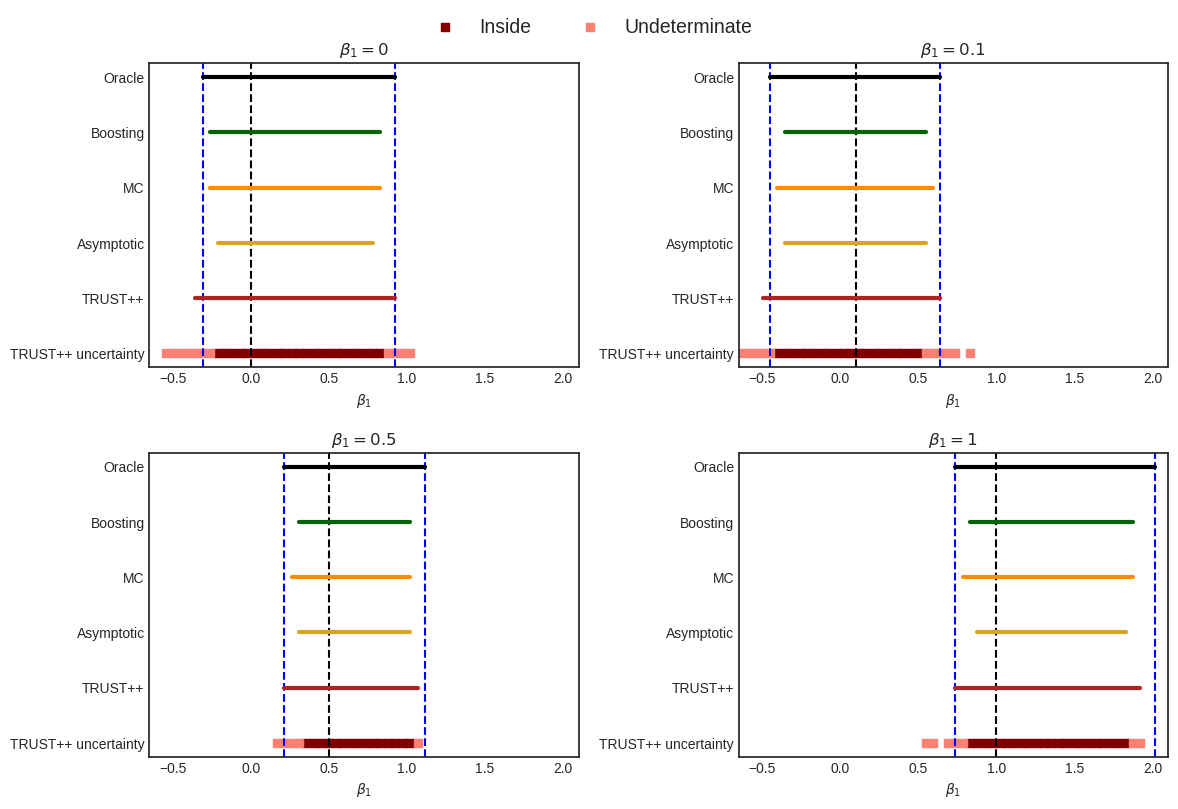

In [51]:
# Create subplots with 2 rows and 2 columns
plt.style.use("seaborn-v0_8-white")
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Define the methods and their corresponding confidence lists and labels
methods = [
    ("TRUST++", TRUST_plus_conf_list, 'firebrick'),  # Dark Red
    ("Asymptotic", asymp_conf_list, "goldenrod"),  # Goldenrod
    ("MC", naive_conf_list, 'darkorange'),  # Dark Orange
    ("Boosting", boosting_conf_list, 'darkgreen'),  # Dark Green
    ("Oracle", oracle_conf_list, 'black'),  # Black
]

uncertainty_list = [
    ("Inside", accept_list, 'maroon'),
    ("Undeterminate", agnostic_list, "salmon")
]

# Flatten the axs array for easier iteration
axs = axs.flatten()
values_list  = [0, 0.1, 0.5, 1]
oracle_inf = [np.min(oracle_conf_list[i]) for i in range(
    len(oracle_conf_list))]
oracle_sup = [np.max(oracle_conf_list[i]) for i in range(
    len(oracle_conf_list))]

j = 0
# Plot all methods in each subplot
for i, ax in enumerate(axs):

    # adding TRUST++ uncertainty
    for label, conf, color in uncertainty_list:
        # selecting i-th entry of conf list
        conf_value = conf[i]
        x = np.repeat(np.array(["TRUST++ uncertainty"]), conf_value.shape[0])
        ax.scatter(conf_value, x, label=label, color=color, marker = ',', )

    for label, conf, color in methods:
        # selecting i-th entry of conf list
        conf_value = conf[i]
        x = np.repeat(np.array([label]), conf_value.shape[0])
        ax.errorbar(conf_value, x, label=label, color=color, lw = 3, )
    
    ax.axvline(x = values_list[j], linestyle = "dashed",
               color = "black")
    
    ax.axvline(x = oracle_inf[j], linestyle = "dashed",
               color = "blue")
    
    ax.axvline(x = oracle_sup[j], linestyle = "dashed",
               color = "blue")
    ax.set_title(rf"$\beta_1 = {values_list[j]}$")
    ax.set_xlabel(r"$\beta_1$")
    ax.set_xlim(-0.65, 2.1)
    j += 1

# Add a legend outside of the panels
handles, labels = axs[0].get_legend_handles_labels()
label_idx = [0, 1]
handles_used = [handles[i] for i in label_idx]
labels_used = [labels[i] for i in label_idx]
plt.rcParams.update({'font.size': 14})
# selecting only the first three labels
fig.legend(
    handles_used, 
    labels_used, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.025),
    ncol=2
    )
plt.tight_layout()
plt.show()
fig.savefig("figures/confidence_intervals_GLM_beta_1.pdf", 
            format="pdf",
            bbox_inches='tight')

Making graphs only for $\beta_1 = 0$ and $\beta_1 = 1$:

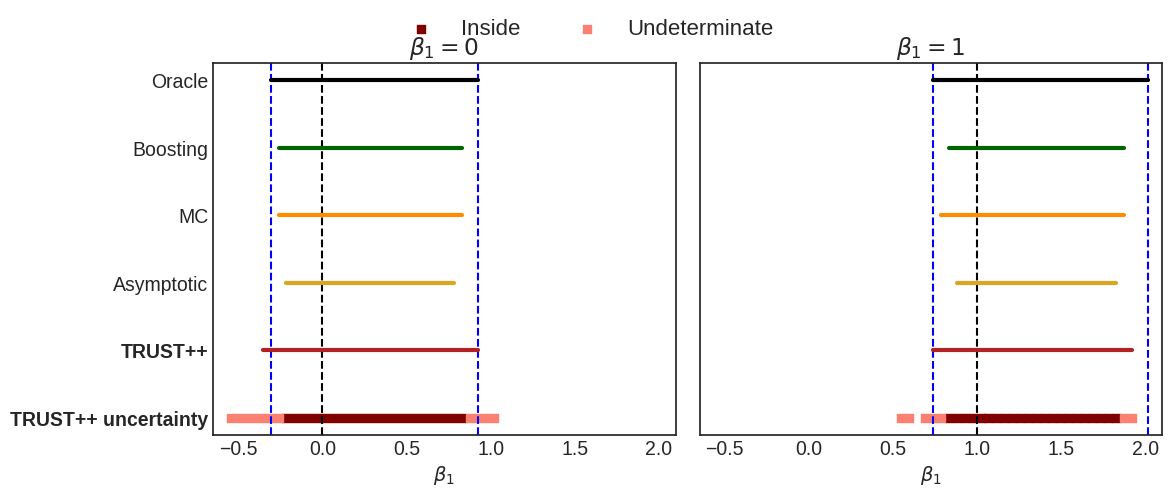

In [52]:
plt.style.use("seaborn-v0_8-white")
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 2 rows, 2 columns
idxs = [0, 3]

# Flatten the axs array for easier iteration
axs = axs.flatten()
values_list  = [0, 1]
oracle_inf = [np.min(oracle_conf_list[i]) for i in range(
    len(oracle_conf_list))]
oracle_sup = [np.max(oracle_conf_list[i]) for i in range(
    len(oracle_conf_list))]

j = 0
# Plot all methods in each subplot
for i, ax in enumerate(axs):
    # adding TRUST++ uncertainty
    for label, conf, color in uncertainty_list:
        # selecting i-th entry of conf list
        conf_value = conf[idxs[i]]
        x = np.repeat(np.array(["TRUST++ uncertainty"]), conf_value.shape[0])
        ax.scatter(conf_value, x, label=label, color=color, marker = ',', )

    for label, conf, color in methods:
        # selecting i-th entry of conf list
        conf_value = conf[idxs[i]]
        x = np.repeat(np.array([label]), conf_value.shape[0])
        ax.errorbar(conf_value, x, label=label, color=color, lw = 3, )
    
    ax.axvline(x = values_list[j], linestyle = "dashed",
               color = "black")
    
    ax.axvline(x = oracle_inf[idxs[j]], linestyle = "dashed",
               color = "blue")
    
    ax.axvline(x = oracle_sup[idxs[j]], linestyle = "dashed",
               color = "blue")
    ax.set_title(rf"$\beta_1 = {values_list[j]}$")
    ax.set_xlabel(r"$\beta_1$")
    ax.set_xlim(-0.65, 2.1)
    j += 1

# Add a legend outside of the panels
handles, labels = axs[0].get_legend_handles_labels()
label_idx = [0, 1]
handles_used = [handles[i] for i in label_idx]
labels_used = [labels[i] for i in label_idx]
plt.rcParams.update({'font.size': 16})
# selecting only the first three labels
fig.legend(
    handles_used, 
    labels_used, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.025),
    ncol=2
    )
axs[1].yaxis.set_ticks([])
for idx in [0, 1]:
            axs[0].get_yticklabels()[idx].set_fontweight("bold")
plt.tight_layout()
plt.show()
fig.savefig("figures/confidence_intervals_GLM_beta_1_small.pdf", 
            format="pdf",
            bbox_inches='tight')

Computing and comparing probability of coverage for each method, generating several Y:

In [53]:
# first for beta_1 = 0
M = 1000
beta_values = np.array([[1, 0, 0.5]])
phi_value = np.array([[1]])

beta_rep_values = np.tile(beta_values, (M, 1))
phi_rep_values = np.tile(phi_value, M)
# simulating Y from X_mat and these beta and phi
Y_sim = glm_class.simulator(beta_rep_values, phi_rep_values)

In [54]:
new_stats_list = []
for Y_fixed in Y_sim:
    stats = compute_stats(Y = Y_fixed,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )
    new_stats_list.append(stats)

/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [55]:
TRUST_plus_cover = np.zeros(M)
naive_cover = np.zeros(M)
asymp_cover = np.zeros(M)
boosting_cover = np.zeros(M)
oracle_cover = np.zeros(M)
j = 0

for stat in new_stats_list:
    TRUST_plus_filter_1 = np.where(stat <= cutoff_TRUST_plus)
    TRUST_plus_conf_temp = beta_1_space[TRUST_plus_filter_1]
    TRUST_plus_cover[j] = (0 >= np.min(TRUST_plus_conf_temp) and 0 <= 
    np.max(TRUST_plus_conf_temp))+ 0

    naive_filter_1 = np.where(stat <= cutoff_naive)
    naive_conf_temp = beta_1_space[naive_filter_1]
    naive_cover[j] = (0 >= np.min(naive_conf_temp)) and (0 <= 
    np.max(naive_conf_temp))+ 0

    asymp_filter_1 = np.where(stat <= cutoff_asymp)
    asymp_conf_temp = beta_1_space[asymp_filter_1]
    asymp_cover[j] = (0 >= np.min(asymp_conf_temp)) and (0 <= 
    np.max(asymp_conf_temp))+ 0

    boosting_filter_1 = np.where(stat <= cutoff_boosting)
    boosting_conf_temp = beta_1_space[boosting_filter_1]
    boosting_cover[j] = (0 >= np.min(boosting_conf_temp)) and (0 <= 
    np.max(boosting_conf_temp))+ 0

    oracle_filter_1 = np.where(stat <= oracle_cutoffs)
    oracle_conf_temp = beta_1_space[oracle_filter_1]
    oracle_cover[j] = (0 >= np.min(oracle_conf_temp)) and (0 <= 
    np.max(oracle_conf_temp))+ 0
    j += 1

In [56]:
oracle_cover_0 = np.mean(oracle_cover)
data_beta_0 = pd.DataFrame(
    {
    "Methods": ["Asymptotic", "MC", "Boosting", "TRUST++"],
    "Probability of coverage": [
        np.mean(asymp_cover), 
        np.mean(naive_cover),
        np.mean(boosting_cover),
        np.mean(TRUST_plus_cover),
    ],
    "se_2": [
        2*np.std(asymp_cover)/np.sqrt(M), 
        2*np.std(naive_cover)/np.sqrt(M),
        2*np.std(boosting_cover)/np.sqrt(M),
        2*np.std(TRUST_plus_cover)/np.sqrt(M),
    ]
    }
    ).assign(
        beta = 0
        )

In [57]:
# first for beta_1 = 0.1
M = 1000
beta_values = np.array([[1, 0.1, 0.5]])
phi_value = np.array([[1]])

beta_rep_values = np.tile(beta_values, (M, 1))
phi_rep_values = np.tile(phi_value, M)
# simulating Y from X_mat and these beta and phi
Y_sim = glm_class.simulator(beta_rep_values, phi_rep_values)

In [58]:
new_stats_list = []
for Y_fixed in Y_sim:
    stats = compute_stats(Y = Y_fixed,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )
    new_stats_list.append(stats)

/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [59]:
TRUST_plus_cover = np.zeros(M)
naive_cover = np.zeros(M)
asymp_cover = np.zeros(M)
boosting_cover = np.zeros(M)
oracle_cover = np.zeros(M)
j = 0

for stat in new_stats_list:
    TRUST_plus_filter_1 = np.where(stat <= cutoff_TRUST_plus)
    TRUST_plus_conf_temp = beta_1_space[TRUST_plus_filter_1]
    TRUST_plus_cover[j] = (0.1 >= np.min(TRUST_plus_conf_temp) and 0.1 <= 
    np.max(TRUST_plus_conf_temp))+ 0

    naive_filter_1 = np.where(stat <= cutoff_naive)
    naive_conf_temp = beta_1_space[naive_filter_1]
    naive_cover[j] = (0.1 >= np.min(naive_conf_temp)) and (0.1 <= 
    np.max(naive_conf_temp))+ 0

    asymp_filter_1 = np.where(stat <= cutoff_asymp)
    asymp_conf_temp = beta_1_space[asymp_filter_1]
    asymp_cover[j] = (0.1 >= np.min(asymp_conf_temp)) and (0.1 <= 
    np.max(asymp_conf_temp))+ 0

    boosting_filter_1 = np.where(stat <= cutoff_boosting)
    boosting_conf_temp = beta_1_space[boosting_filter_1]
    boosting_cover[j] = (0.1 >= np.min(boosting_conf_temp)) and (0.1 <= 
    np.max(boosting_conf_temp))+ 0

    oracle_filter_1 = np.where(stat <= oracle_cutoffs)
    oracle_conf_temp = beta_1_space[oracle_filter_1]
    oracle_cover[j] = (0.1 >= np.min(oracle_conf_temp)) and (0.1 <= 
    np.max(oracle_conf_temp))+ 0
    j += 1

In [60]:
oracle_cover_0_1 = np.mean(oracle_cover)

data_beta_0_1 = pd.DataFrame(
    {
    "Methods": ["Asymptotic", "MC", "Boosting", "TRUST++"],
    "Probability of coverage": [
        np.mean(asymp_cover), 
        np.mean(naive_cover),
        np.mean(boosting_cover),
        np.mean(TRUST_plus_cover),
    ],
    "se_2": [
        2*np.std(asymp_cover)/np.sqrt(M), 
        2*np.std(naive_cover)/np.sqrt(M),
        2*np.std(boosting_cover)/np.sqrt(M),
        2*np.std(TRUST_plus_cover)/np.sqrt(M),
    ]
    }
    ).assign(
        beta = 0.1
        )

In [61]:
# first for beta_1 = 0.5
M = 1000
beta_values = np.array([[1, 0.5, 0.5]])
phi_value = np.array([[1]])

beta_rep_values = np.tile(beta_values, (M, 1))
phi_rep_values = np.tile(phi_value, M)
# simulating Y from X_mat and these beta and phi
Y_sim = glm_class.simulator(beta_rep_values, phi_rep_values)

In [62]:
new_stats_list = []
for Y_fixed in Y_sim:
    stats = compute_stats(Y = Y_fixed,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )
    new_stats_list.append(stats)

/home/kuben45/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [63]:
TRUST_plus_cover = np.zeros(M)
naive_cover = np.zeros(M)
asymp_cover = np.zeros(M)
boosting_cover = np.zeros(M)
oracle_cover = np.zeros(M)
j = 0

for stat in new_stats_list:
    TRUST_plus_filter_1 = np.where(stat <= cutoff_TRUST_plus)
    TRUST_plus_conf_temp = beta_1_space[TRUST_plus_filter_1]
    TRUST_plus_cover[j] = (0.5 >= np.min(TRUST_plus_conf_temp) and 0.5 <= 
    np.max(TRUST_plus_conf_temp))+ 0

    naive_filter_1 = np.where(stat <= cutoff_naive)
    naive_conf_temp = beta_1_space[naive_filter_1]
    naive_cover[j] = (0.5 >= np.min(naive_conf_temp)) and (0.5 <= 
    np.max(naive_conf_temp))+ 0

    asymp_filter_1 = np.where(stat <= cutoff_asymp)
    asymp_conf_temp = beta_1_space[asymp_filter_1]
    asymp_cover[j] = (0.5 >= np.min(asymp_conf_temp)) and (0.5 <= 
    np.max(asymp_conf_temp))+ 0

    boosting_filter_1 = np.where(stat <= cutoff_boosting)
    boosting_conf_temp = beta_1_space[boosting_filter_1]
    boosting_cover[j] = (0.5 >= np.min(boosting_conf_temp)) and (0.5 <= 
    np.max(boosting_conf_temp))+ 0

    oracle_filter_1 = np.where(stat <= oracle_cutoffs)
    oracle_conf_temp = beta_1_space[oracle_filter_1]
    oracle_cover[j] = (0.5 >= np.min(oracle_conf_temp)) and (0.5 <= 
    np.max(oracle_conf_temp))+ 0
    j += 1

In [64]:
oracle_cover_0_5 = np.mean(oracle_cover)

data_beta_0_5 = pd.DataFrame(
    {
    "Methods": ["Asymptotic", "MC", "Boosting", "TRUST++"],
    "Probability of coverage": [
        np.mean(asymp_cover), 
        np.mean(naive_cover),
        np.mean(boosting_cover),
        np.mean(TRUST_plus_cover),
    ],
    "se_2": [
        2*np.std(asymp_cover)/np.sqrt(M), 
        2*np.std(naive_cover)/np.sqrt(M),
        2*np.std(boosting_cover)/np.sqrt(M),
        2*np.std(TRUST_plus_cover)/np.sqrt(M),
    ]
    }
    ).assign(
        beta = 0.5
        )

In [67]:
# first for beta_1 = 1
M = 1000
beta_values = np.array([[1, 1, 0.5]])
phi_value = np.array([[1]])

beta_rep_values = np.tile(beta_values, (M, 1))
phi_rep_values = np.tile(phi_value, M)
# simulating Y from X_mat and these beta and phi
Y_sim = glm_class.simulator(beta_rep_values, phi_rep_values)

In [68]:
new_stats_list = []
for Y_fixed in Y_sim:
    stats = compute_stats(Y = Y_fixed,
                           X = X_mat,
                           beta_space = beta_1_space,
                           glm_class = glm_class,
                           )
    new_stats_list.append(stats)

In [69]:
TRUST_plus_cover = np.zeros(M)
naive_cover = np.zeros(M)
asymp_cover = np.zeros(M)
boosting_cover = np.zeros(M)
oracle_cover = np.zeros(M)
j = 0

for stat in new_stats_list:
    TRUST_plus_filter_1 = np.where(stat <= cutoff_TRUST_plus)
    TRUST_plus_conf_temp = beta_1_space[TRUST_plus_filter_1]
    TRUST_plus_cover[j] = (1 >= np.min(TRUST_plus_conf_temp) and 1 <= 
    np.max(TRUST_plus_conf_temp))+ 0

    naive_filter_1 = np.where(stat <= cutoff_naive)
    naive_conf_temp = beta_1_space[naive_filter_1]
    naive_cover[j] = (1 >= np.min(naive_conf_temp)) and (1 <= 
    np.max(naive_conf_temp))+ 0

    asymp_filter_1 = np.where(stat <= cutoff_asymp)
    asymp_conf_temp = beta_1_space[asymp_filter_1]
    asymp_cover[j] = (1 >= np.min(asymp_conf_temp)) and (1 <= 
    np.max(asymp_conf_temp))+ 0

    boosting_filter_1 = np.where(stat <= cutoff_boosting)
    boosting_conf_temp = beta_1_space[boosting_filter_1]
    boosting_cover[j] = (1 >= np.min(boosting_conf_temp)) and (1 <= 
    np.max(boosting_conf_temp))+ 0

    oracle_filter_1 = np.where(stat <= oracle_cutoffs)
    oracle_conf_temp = beta_1_space[oracle_filter_1]
    oracle_cover[j] = (1 >= np.min(oracle_conf_temp)) and (1 <= 
    np.max(oracle_conf_temp))+ 0
    j += 1

In [70]:
oracle_cover_1 = np.mean(oracle_cover)

data_beta_1 = pd.DataFrame(
    {
    "Methods": ["Asymptotic", "MC", "Boosting", "TRUST++"],
    "Probability of coverage": [
        np.mean(asymp_cover), 
        np.mean(naive_cover),
        np.mean(boosting_cover),
        np.mean(TRUST_plus_cover),
    ],
    "se_2": [
        2*np.std(asymp_cover)/np.sqrt(M), 
        2*np.std(naive_cover)/np.sqrt(M),
        2*np.std(boosting_cover)/np.sqrt(M),
        2*np.std(TRUST_plus_cover)/np.sqrt(M)
    ]
    }
    ).assign(
        beta = 1
        )

In [73]:
data_beta_1["Probability of coverage"]

0    0.072
1    0.047
2    0.051
3    0.026
Name: Probability of coverage, dtype: float64

### Plotting probability of coverage for each method:

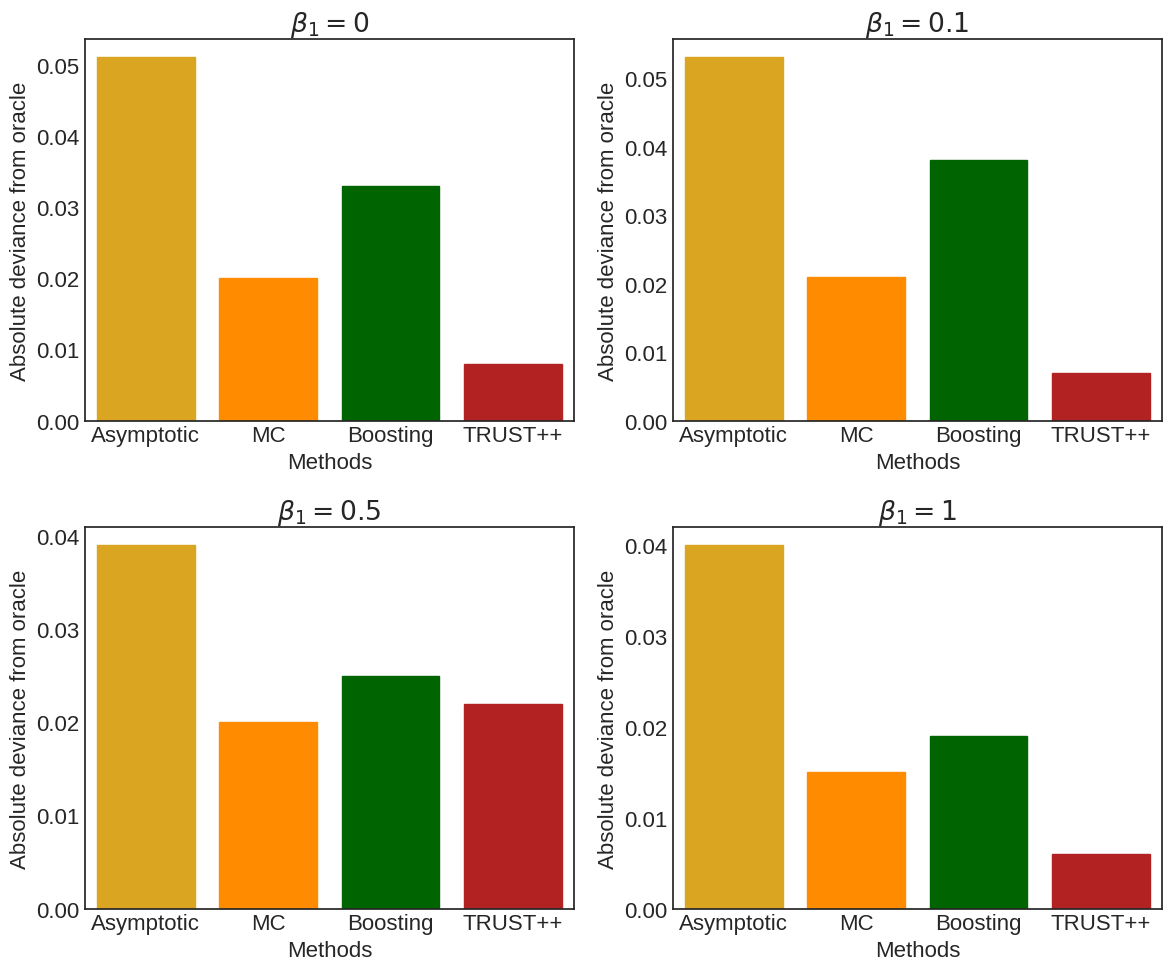

In [77]:
import seaborn as sns

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# List of dataframes and titles
data_list = [data_beta_0, data_beta_0_1, data_beta_0_5, data_beta_1]
oracle_list = [
    oracle_cover_0, oracle_cover_0_1, oracle_cover_0_5, oracle_cover_1
    ]
titles = [r'$\beta_1 = 0$', r'$\beta_1 = 0.1$', r'$\beta_1 = 0.5$', r'$\beta_1 = 1$']

# Plot each dataframe in a separate subplot
for ax, data, oracle, title in zip(
    axs.flatten(), data_list, oracle_list, titles):
    new_data = data.assign(dev = np.abs(data['Probability of coverage'] - oracle))
    sns.barplot(x='Methods', y='dev', data=new_data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Methods')
    ax.set_ylabel('Absolute deviance from oracle')
    # Set colors for each method
    colors = {'MC': 'darkorange', 'Boosting': 'darkgreen', 'Asymptotic': 'goldenrod', 'TRUST++': 'firebrick'}
    for patch in ax.patches:
        method = patch.get_x() + patch.get_width() / 2
        method_name = data['Methods'].iloc[int(method)]
        patch.set_color(colors[method_name])

plt.rcParams.update({'font.size': 16})
# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig("figures/coverage_deviance_GLM_beta_1.pdf", format="pdf")

Only for $\beta_1 = 0$ and $\beta_1 = 1$:

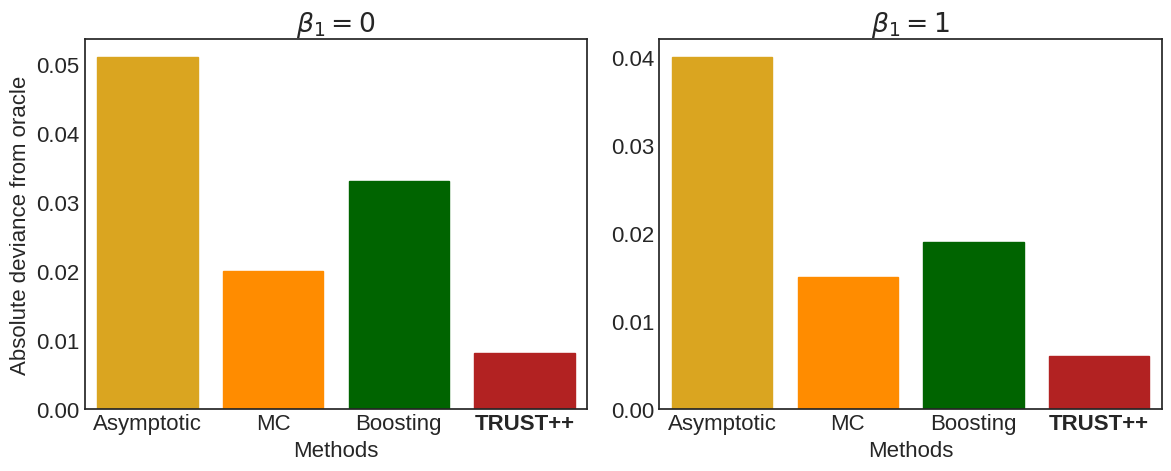

In [78]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 
idxs = [0, 3]

# List of dataframes and titles
data_list = [data_beta_0, data_beta_1]
oracle_list = [
    oracle_cover_0, oracle_cover_1
    ]
titles = [r'$\beta_1 = 0$', r'$\beta_1 = 1$']

# Plot each dataframe in a separate subplot
for ax, data, oracle, title in zip(
    axs.flatten(), data_list, oracle_list, titles):
    new_data = data.assign(dev = np.abs(data['Probability of coverage'] - oracle))
    sns.barplot(x='Methods', y='dev', data=new_data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Methods')
    ax.set_ylabel('Absolute deviance from oracle')
    # Set colors for each method
    colors = {'MC': 'darkorange', 'Boosting': 'darkgreen', 'Asymptotic': 'goldenrod', 'TRUST++': 'firebrick'}
    for patch in ax.patches:
        method = patch.get_x() + patch.get_width() / 2
        method_name = data['Methods'].iloc[int(method)]
        patch.set_color(colors[method_name])
    ax.get_xticklabels()[3].set_fontweight("bold")
        
axs[1].set_ylabel("")
plt.rcParams.update({'font.size': 16})
# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig("figures/prob_of_coverage_GLM_beta_1_small.pdf", format="pdf")